In [ ]:
!pip install numpy pandas matplotlib torch torchkan pykan arch kan

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class PerformanceBasedWeights(nn.Module):
    """Dynamic weights based on recent model performance"""

    def __init__(self, window_size, alpha=0.1):
        super().__init__()
        self.window_size = window_size
        self.alpha = alpha  # Smoothing factor for exponential moving average

        # Performance tracking buffers
        self.register_buffer('kan_errors', torch.zeros(window_size))
        self.register_buffer('garch_errors', torch.zeros(window_size))
        self.register_buffer('update_counter', torch.tensor(0, dtype=torch.long))

        # Exponential moving average of errors
        self.register_buffer('kan_ema_error', torch.tensor(0.1))
        self.register_buffer('garch_ema_error', torch.tensor(0.1))

        # Weight bounds for stability
        self.min_weight = 0.1
        self.max_weight = 0.9

        # Current weights (initialized to equal)
        self.register_buffer('current_kan_weight', torch.tensor(0.5))
        self.register_buffer('current_garch_weight', torch.tensor(0.5))

    def update_performance(self, kan_pred, garch_pred, true_values):
        # FIXED: Prevent gradient computation for performance tracking
        with torch.no_grad():
            kan_error = F.mse_loss(kan_pred, true_values, reduction='mean')
            garch_error = F.mse_loss(garch_pred, true_values, reduction='mean')
            # ... rest of the method (keep everything else the same)

        # Update circular buffer
        idx = self.update_counter % self.window_size
        self.kan_errors[idx] = kan_error
        self.garch_errors[idx] = garch_error
        self.update_counter += 1

        # Update exponential moving averages
        if self.update_counter == 1:
            self.kan_ema_error = kan_error
            self.garch_ema_error = garch_error
        else:
            self.kan_ema_error = (1 - self.alpha) * self.kan_ema_error + self.alpha * kan_error
            self.garch_ema_error = (1 - self.alpha) * self.garch_ema_error + self.alpha * garch_error

        # Calculate new weights based on recent performance
        self._update_weights()

    def _update_weights(self):
        """Update weights based on recent performance"""
        if self.update_counter < 3:  # Need minimum samples
            return

        # Use samples we have so far
        n_samples = min(self.update_counter, self.window_size)
        recent_kan_errors = self.kan_errors[:n_samples]
        recent_garch_errors = self.garch_errors[:n_samples]

        # Calculate average recent performance
        avg_kan_error = torch.mean(recent_kan_errors) + 1e-8
        avg_garch_error = torch.mean(recent_garch_errors) + 1e-8

        # Inverse error weighting (better performance = higher weight)
        kan_performance = 1.0 / avg_kan_error
        garch_performance = 1.0 / avg_garch_error

        # Normalize weights
        total_performance = kan_performance + garch_performance
        new_kan_weight = kan_performance / total_performance
        new_garch_weight = garch_performance / total_performance

        # Apply bounds for stability
        new_kan_weight = torch.clamp(new_kan_weight, self.min_weight, self.max_weight)
        new_garch_weight = 1.0 - new_kan_weight

        # Smooth weight transitions
        smoothing = 0.3
        self.current_kan_weight = (1 - smoothing) * self.current_kan_weight + smoothing * new_kan_weight
        self.current_garch_weight = (1 - smoothing) * self.current_garch_weight + smoothing * new_garch_weight

        # Ensure weights sum to 1
        total = self.current_kan_weight + self.current_garch_weight
        self.current_kan_weight = self.current_kan_weight / total
        self.current_garch_weight = self.current_garch_weight / total

    def get_weights(self):
        """Get current performance-based weights"""
        return self.current_kan_weight, self.current_garch_weight

    def forward(self, kan_output, garch_output):
        """Apply current weights to model outputs"""
        kan_w, garch_w = self.get_weights()

        # Apply weights (ensure proper dimensions)
        kan_contrib = kan_w * kan_output.mean(dim=1, keepdim=True)
        garch_contrib = garch_w * garch_output

        return kan_contrib + garch_contrib, {
            'kan_weight': kan_w,
            'garch_weight': garch_w,
            'kan_performance': 1.0 / (self.kan_ema_error + 1e-8),
            'garch_performance': 1.0 / (self.garch_ema_error + 1e-8)
        }

In [ ]:
class ImprovedBSplineKAN(nn.Module):
    """Improved B-spline KAN layer with better numerical stability"""

    def __init__(self, in_features: int, out_features: int, grid_size: int = 5,
                 spline_order: int = 3, scale_noise: float = 0.01):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        # Grid points for B-splines
        h = 2.0 / grid_size
        grid = torch.linspace(-1 - h * spline_order, 1 + h * spline_order,
                             grid_size + 2 * spline_order + 1)
        self.register_buffer('grid', grid)

        # Learnable coefficients
        self.coefficients = nn.Parameter(
            torch.randn(out_features, in_features, grid_size + spline_order) * scale_noise
        )

        # Base linear transformation for stability
        self.base_weight = nn.Parameter(torch.randn(out_features, in_features) * scale_noise)

        # Scale factor
        self.scale = nn.Parameter(torch.ones(out_features))

    def b_splines(self, x: torch.Tensor) -> torch.Tensor:
        """Compute B-spline basis functions"""
        assert x.dim() == 2 and x.size(1) == self.in_features

        x = torch.clamp(x, -0.99, 0.99)  # Clamp to avoid boundary issues

        # Find the appropriate knot intervals
        grid = self.grid
        bases = []

        for i in range(len(grid) - self.spline_order - 1):
            base = torch.ones_like(x)  # Start with degree 0

            for p in range(1, self.spline_order + 1):
                # Left term
                left_denom = grid[i + p] - grid[i]
                if left_denom > 1e-8:
                    left = (x - grid[i]) / left_denom
                    left = torch.where((x >= grid[i]) & (x < grid[i + p]), left, torch.zeros_like(x))
                else:
                    left = torch.zeros_like(x)

                # Right term
                right_denom = grid[i + p + 1] - grid[i + 1]
                if right_denom > 1e-8:
                    right = (grid[i + p + 1] - x) / right_denom
                    right = torch.where((x >= grid[i + 1]) & (x < grid[i + p + 1]), right, torch.zeros_like(x))
                else:
                    right = torch.zeros_like(x)

                base = left * base + right * base

            # Only keep non-zero bases
            mask = (x >= grid[i]) & (x < grid[i + self.spline_order + 1])
            base = torch.where(mask, base, torch.zeros_like(x))
            bases.append(base)

        return torch.stack(bases, dim=-1)  # [batch, in_features, num_bases]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Normalize input to [-1, 1]
        x_normalized = torch.tanh(x)

        # Compute B-spline bases
        bases = self.b_splines(x_normalized)  # [batch, in_features, num_bases]

        # Apply spline transformation
        spline_output = torch.zeros(x.size(0), self.out_features, device=x.device)

        for i in range(self.out_features):
            for j in range(self.in_features):
                spline_output[:, i] += torch.sum(
                    bases[:, j, :] * self.coefficients[i, j, :], dim=-1
                )

        # Add base linear transformation
        linear_output = F.linear(x_normalized, self.base_weight)

        # Combine and scale
        output = self.scale * (spline_output + 0.1 * linear_output)

        return output

In [ ]:
class VolatilityKAN(nn.Module):
    """Improved KAN architecture for volatility prediction"""

    def __init__(self, input_dim: int, hidden_dims: list, output_dim: int = 1,
                 dropout_rate: float = 0.2):
        super().__init__()

        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        self.layer_norms = nn.ModuleList()

        for i in range(len(dims) - 1):
            self.layers.append(
                ImprovedBSplineKAN(dims[i], dims[i+1], grid_size=5, spline_order=3)
            )

            if i < len(dims) - 2:  # No dropout/norm on output layer
                self.dropouts.append(nn.Dropout(dropout_rate))
                self.layer_norms.append(nn.LayerNorm(dims[i+1]))

        # Output activation for positive volatility
        self.output_activation = nn.Softplus(beta=1.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i, layer in enumerate(self.layers):
            x = layer(x)

            if i < len(self.layers) - 1:  # Not the output layer
                x = self.layer_norms[i](x)
                x = F.silu(x)  # SiLU works well with KAN
                x = self.dropouts[i](x)

        return self.output_activation(x)

In [ ]:
class HybridKANGARCHWithPerformanceWeights(nn.Module):
    """Fixed Hybrid KAN-GARCH model with performance-based dynamic weights"""

    def __init__(self, input_dim, garch_dim, hidden_dims=[64, 32, 16],
                 output_dim=1, dropout_rate=0.3, window=30):
        super().__init__()

        # KAN component
        self.kan_component = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.Tanh(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.Tanh(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dims[1], hidden_dims[2])
        )

        # GARCH component
        self.garch_component = nn.Sequential(
            nn.Linear(garch_dim, 16),
            nn.Tanh(),
            nn.Linear(16, 8),
            nn.Tanh(),
            nn.Linear(8, 1),
            nn.Softplus()
        )

        # Performance-based weight manager
        self.weight_manager = PerformanceBasedWeights(window_size=window)

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dims[2] + 1, 32),
            nn.Tanh(),
            nn.Dropout(dropout_rate/2),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, output_dim),
            nn.Softplus()
        )

    def forward(self, x_features, x_garch, true_values=None, update_weights=True):
        """Forward pass with performance-based weight adaptation"""
        # Get component outputs
        kan_output = self.kan_component(x_features)
        garch_output = self.garch_component(x_garch)

        # Update performance tracking during training
        if self.training and true_values is not None and update_weights:
            # FIXED: Detach tensors to prevent double backward
            kan_pred = kan_output.mean(dim=1, keepdim=True).detach()
            garch_pred = garch_output.detach()
            true_vals = true_values.detach()
            self.weight_manager.update_performance(kan_pred, garch_pred, true_vals)

        # Get performance-based weighted combination
        weighted_output, weight_info = self.weight_manager(kan_output, garch_output)

        # Final fusion
        combined = torch.cat([kan_output, garch_output], dim=1)
        fusion_output = self.fusion(combined)

        # Final output combines fusion and weighted components
        final_output = fusion_output + 0.1 * weighted_output

        return final_output, weight_info

In [ ]:
def calculate_technical_indicators(returns: np.ndarray, prices: np.ndarray) -> dict:
    """Calculate various technical indicators"""
    indicators = {}

    # RSI
    gains = np.where(returns > 0, returns, 0)
    losses = np.where(returns < 0, -returns, 0)
    avg_gain = np.mean(gains[-14:]) if len(gains) >= 14 else np.mean(gains)
    avg_loss = np.mean(losses[-14:]) if len(losses) >= 14 else np.mean(losses)
    rs = avg_gain / (avg_loss + 1e-8)
    indicators['rsi'] = 100 - (100 / (1 + rs))

    # Bollinger Bands position
    if len(prices) >= 20:
        sma20 = np.mean(prices[-20:])
        std20 = np.std(prices[-20:])
        bb_position = (prices[-1] - sma20) / (2 * std20 + 1e-8)
        indicators['bb_position'] = np.clip(bb_position, -2, 2)
    else:
        indicators['bb_position'] = 0

    # Price momentum
    if len(prices) >= 10:
        indicators['momentum_10'] = (prices[-1] - prices[-10]) / (prices[-10] + 1e-8)
    else:
        indicators['momentum_10'] = 0

    return indicators

In [ ]:
def create_garch_features(returns: np.ndarray, vol_window: int = 30) -> np.ndarray:
    """Create GARCH-specific features"""
    window = vol_window
    if len(returns) < window:
        return np.array([0, 0, 0])

    recent_returns = returns[-window:]

    # Squared returns (proxy for volatility)
    squared_returns = recent_returns ** 2
    current_sq_return = squared_returns[-1]

    # Moving average of squared returns
    ma_sq_returns = np.mean(squared_returns)

    # Volatility persistence (autocorrelation of squared returns)
    if len(squared_returns) > 1:
        persistence = np.corrcoef(squared_returns[1:], squared_returns[:-1])[0, 1]
        persistence = 0 if np.isnan(persistence) else persistence
    else:
        persistence = 0

    return np.array([current_sq_return, ma_sq_returns, persistence])

In [ ]:
def create_volatility_features(data: pd.DataFrame, lookback: int = 30, vol_window: int = 30) -> tuple:
    """Create comprehensive volatility features"""

    # Calculate basic returns and volatility
    price_col = 'Adjusted' if 'Adjusted' in data.columns else 'Close'
    data['Returns'] = data[price_col].pct_change()
    data['LogReturns'] = np.log(data[price_col]).diff()

    window = vol_window
    # Calculate rolling volatility
    col_name = f'RollingVol_{window}'
    data[col_name] = data['LogReturns'].rolling(window=window, min_periods=window//2).std() * np.sqrt(252)

    # Use as primary target
    data['RollingVol'] = data[col_name]
    data.dropna(inplace=True)

    features = []
    garch_features = []
    targets = []

    # Ensure we have enough data
    min_start = max(lookback, window)

    for i in range(min_start, len(data)):
        # Historical data window
        hist_returns = data['LogReturns'].iloc[i-lookback:i].values
        hist_prices = data[price_col].iloc[i-lookback:i].values
        hist_vol = data[col_name].iloc[i-lookback:i].values

        feature_vector = []

        # Basic volatility features
        current_vol = hist_vol[-1] if not np.isnan(hist_vol[-1]) else 0
        feature_vector.append(current_vol)

        # Moving averages
        vol_ma5 = np.nanmean(hist_vol[-5:]) if len(hist_vol) >= 5 else current_vol
        feature_vector.append(vol_ma5)

        vol_ma20 = np.nanmean(hist_vol[-20:]) if len(hist_vol) >= 20 else current_vol
        vol_std = np.nanstd(hist_vol[-20:]) if len(hist_vol) >= 20 else 0
        feature_vector.extend([vol_ma20, vol_std])

        # Volatility trend
        vol_trend = (hist_vol[-1] - hist_vol[-10]) / (hist_vol[-10] + 1e-8) if len(hist_vol) >= 10 else 0
        feature_vector.append(vol_trend)

        # Volatility percentile
        vol_percentile = np.sum(hist_vol <= current_vol) / len(hist_vol) if len(hist_vol) > 1 else 0.5
        feature_vector.append(vol_percentile)

        # Return-based features
        return_mean = np.mean(hist_returns)
        return_std = np.std(hist_returns)
        return_skew = np.mean(((hist_returns - return_mean) / (return_std + 1e-8))**3) if return_std > 1e-8 else 0
        return_kurt = np.mean(((hist_returns - return_mean) / (return_std + 1e-8))**4) if return_std > 1e-8 else 0
        feature_vector.extend([return_mean, return_std, return_skew, return_kurt])

        # Regime features
        high_vol_days = np.sum(hist_vol > np.nanpercentile(hist_vol, 75)) / len(hist_vol)
        feature_vector.append(high_vol_days)

        # Asymmetric volatility
        neg_returns = hist_returns[hist_returns < 0]
        pos_returns = hist_returns[hist_returns > 0]
        neg_vol = np.std(neg_returns) if len(neg_returns) > 1 else 0
        pos_vol = np.std(pos_returns) if len(pos_returns) > 1 else 0
        asym_ratio = neg_vol / (pos_vol + 1e-8)
        feature_vector.append(asym_ratio)

        # Technical indicators
        tech_indicators = calculate_technical_indicators(hist_returns, hist_prices)
        feature_vector.extend([
            tech_indicators['rsi'] / 100.0,
            tech_indicators['bb_position'],
            tech_indicators['momentum_10']
        ])

        # Volatility autocorrelation
        vol_autocorr = np.corrcoef(hist_vol[1:], hist_vol[:-1])[0,1] if len(hist_vol) > 1 else 0
        vol_autocorr = 0 if np.isnan(vol_autocorr) else vol_autocorr
        feature_vector.append(vol_autocorr)

        # Volatility clustering
        squared_returns = hist_returns**2
        vol_clustering = np.corrcoef(squared_returns[1:], squared_returns[:-1])[0,1] if len(hist_returns) > 1 else 0
        vol_clustering = 0 if np.isnan(vol_clustering) else vol_clustering
        feature_vector.append(vol_clustering)

        # Create GARCH-specific features
        garch_feat = create_garch_features(hist_returns, min(window, len(hist_returns)))

        features.append(feature_vector)
        garch_features.append(garch_feat)
        targets.append(data['RollingVol'].iloc[i])

    return np.array(features), np.array(garch_features), np.array(targets)

In [ ]:
def fit_garch_model(returns: np.ndarray):
    """Fit GARCH(1,1) model"""
    from arch import arch_model

    # Convert to percentage returns for stability
    returns_pct = returns * 100

    # Fit GARCH(1,1) model
    garch = arch_model(returns_pct, vol='Garch', p=1, q=1, rescale=False)
    garch_fit = garch.fit(disp="off", show_warning=False)

    # Get conditional volatility (convert back to decimal and annualize)
    conditional_vol = garch_fit.conditional_volatility / 100 * np.sqrt(252)

    # Get model parameters
    params = garch_fit.params

    return conditional_vol, garch_fit, params

In [ ]:
def train_model_with_performance_weights(data: pd.DataFrame, lookback: int = 30, vol_window: int = 30):
    """Train KAN, GARCH, and Hybrid models"""
    epochs = 200
    window = vol_window
    print("Creating volatility features...")
    X, X_garch, y = create_volatility_features(data.copy(), lookback, window)

    print(f"Feature matrix shape: {X.shape}")
    print(f"GARCH feature matrix shape: {X_garch.shape}")
    print(f"Target vector shape: {y.shape}")

    # Train/test split
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    X_garch_train, X_garch_test = X_garch[:split_idx], X_garch[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Feature scaling
    scaler_X = StandardScaler()
    scaler_X_garch = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    X_garch_train_scaled = scaler_X_garch.fit_transform(X_garch_train)
    X_garch_test_scaled = scaler_X_garch.transform(X_garch_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    X_garch_train_tensor = torch.tensor(X_garch_train_scaled, dtype=torch.float32)
    X_garch_test_tensor = torch.tensor(X_garch_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)

    # Prepare GARCH model data
    price_col = 'Adjusted' if 'Adjusted' in data.columns else 'Close'
    returns = data[price_col].pct_change().dropna().values

    print("\n" + "="*50)
    print("TRAINING MODELS")
    print("="*50)

    results = {}

    # 1. Train KAN Model
    print("\n1. Training KAN Model...")
    kan_model = VolatilityKAN(
        input_dim=X.shape[1],
        hidden_dims=[64, 32, 16],
        output_dim=1,
        dropout_rate=0.3
    )

    kan_optimizer = optim.AdamW(kan_model.parameters(), lr=0.01, weight_decay=1e-5)
    kan_scheduler = optim.lr_scheduler.CosineAnnealingLR(kan_optimizer, T_max=100, eta_min=1e-5)
    criterion = nn.MSELoss()

    kan_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    kan_dataloader = DataLoader(kan_dataset, batch_size=64, shuffle=True)

    kan_train_losses = []
    kan_test_losses = []

    best_test_loss = float('inf')
    patience = 0

    for epoch in range(epochs):
        kan_model.train()
        epoch_loss = 0

        for batch_X, batch_y in kan_dataloader:
            kan_optimizer.zero_grad()
            pred = kan_model(batch_X)
            loss = criterion(pred, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(kan_model.parameters(), max_norm=0.5)
            kan_optimizer.step()
            epoch_loss += loss.item()

        kan_model.eval()
        with torch.no_grad():
            test_pred = kan_model(X_test_tensor)
            test_loss = criterion(test_pred, y_test_tensor).item()

        kan_scheduler.step()

        avg_train_loss = epoch_loss / len(kan_dataloader)
        kan_train_losses.append(avg_train_loss)
        kan_test_losses.append(test_loss)
        # Early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience = 0
        else:
            patience += 1

        if patience > 20:
            print(f"Early stopping at epoch {epoch}")
            break
        # if epoch % 30 == 0:
        print(f"KAN Epoch {epoch}: Train={avg_train_loss:.6f}, Test={test_loss:.6f}")

    # Get KAN predictions
    kan_model.eval()
    with torch.no_grad():
        kan_pred_train = kan_model(X_train_tensor).numpy()
        kan_pred_train = scaler_y.inverse_transform(kan_pred_train).flatten()

        # Test predictions
        kan_pred_test = kan_model(X_test_tensor).numpy()
        kan_pred_test = scaler_y.inverse_transform(kan_pred_test).flatten()

    results['kan'] = {
        'model': kan_model,
        'predictions': kan_pred_test.flatten(),
        'train_predictions': kan_pred_train.flatten(),
        'train_losses': kan_train_losses,
        'test_losses': kan_test_losses
    }

    # 2. Fit GARCH Model
    print("\n2. Fitting GARCH Model...")
    garch_vol, garch_fit, garch_params = fit_garch_model(returns)

    # Align GARCH predictions with test set
    if garch_vol is not None:
        # For train set
        garch_train_start = len(garch_vol) - len(y_train) - len(y_test)
        if garch_train_start >= 0:
            garch_pred_train = garch_vol[garch_train_start:garch_train_start + len(y_train)]
        else:
            # If not enough GARCH data, pad with zeros or use available data
            available_train_len = max(0, len(garch_vol) - len(y_test))
            if available_train_len > 0:
                garch_pred_train = garch_vol[:available_train_len]
                # Pad or truncate to match y_train length
                if len(garch_pred_train) < len(y_train):
                    padding = np.zeros(len(y_train) - len(garch_pred_train))
                    garch_pred_train = np.concatenate([padding, garch_pred_train])
                elif len(garch_pred_train) > len(y_train):
                    garch_pred_train = garch_pred_train[-len(y_train):]
            else:
                garch_pred_train = np.zeros_like(y_train)

        # For test set
        garch_test_start = len(garch_vol) - len(y_test)
        garch_pred_test = garch_vol[garch_test_start:] if garch_test_start >= 0 else garch_vol

        # Ensure same length
        min_len = min(len(garch_pred_test), len(y_test))
        garch_pred_test = garch_pred_test[-min_len:]
        y_test_aligned = y_test[-min_len:]
    else:
        garch_pred_test = np.zeros_like(y_test)
        garch_pred_train = np.zeros_like(y_train)
        y_test_aligned = y_test
        y_train_aligned = y_train

    results['garch'] = {
        'model': garch_fit,
        'predictions': garch_pred_test,
        'train_predictions': garch_pred_train,
        'params': garch_params
    }

    # 3. Train Hybrid Model
    print("\n3. Training Hybrid KAN-GARCH Model...")
    hybrid_model = HybridKANGARCHWithPerformanceWeights(
        input_dim=X.shape[1],
        garch_dim=X_garch.shape[1],
        hidden_dims=[64, 32, 16],
        output_dim=1,
        dropout_rate=0.3,
        window=window
    )

    hybrid_optimizer = optim.AdamW(hybrid_model.parameters(), lr=0.008, weight_decay=1e-5)
    hybrid_scheduler = optim.lr_scheduler.CosineAnnealingLR(hybrid_optimizer, T_max=120, eta_min=1e-5)

    hybrid_dataset = TensorDataset(X_train_tensor, X_garch_train_tensor, y_train_tensor)
    hybrid_dataloader = DataLoader(hybrid_dataset, batch_size=64, shuffle=True)

    hybrid_train_losses = []
    hybrid_test_losses = []
    weight_history = []
    best_test_loss_h = float('inf')
    patience_h = 0

    for epoch in range(epochs):
        hybrid_model.train()
        epoch_loss = 0

        for batch_X, batch_X_garch, batch_y in hybrid_dataloader:
            hybrid_optimizer.zero_grad()
            output, weight_info = hybrid_model(batch_X, batch_X_garch, batch_y, update_weights=True)
            loss = criterion(output, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(hybrid_model.parameters(), max_norm=0.5)
            hybrid_optimizer.step()
            epoch_loss += loss.item()

        hybrid_model.eval()
        with torch.no_grad():
            test_output, test_weight_info = hybrid_model(X_test_tensor, X_garch_test_tensor,
                                                y_test_tensor, update_weights=False)
            test_loss = criterion(test_output, y_test_tensor).item()

        hybrid_scheduler.step()

        avg_train_loss = epoch_loss / len(hybrid_dataloader)
        hybrid_train_losses.append(avg_train_loss)
        hybrid_test_losses.append(test_loss)
        weight_history.append({
            'epoch': epoch,
            'kan_weight': weight_info['kan_weight'].item(),
            'garch_weight': weight_info['garch_weight'].item(),
            'kan_performance': weight_info['kan_performance'].item(),
            'garch_performance': weight_info['garch_performance'].item()
        })

        if test_loss < best_test_loss_h:
            best_test_loss_h = test_loss
            patience_h = 0
        else:
            patience_h += 1

        if patience_h > 20:
            print(f"Early stopping at epoch {epoch}")
            break

        print(f"Hybrid {epoch:3d}: Train={avg_train_loss:.6f}, Test={test_loss:.6f}, "
              f"KAN_w={weight_info['kan_weight'].item():.3f}, "
              f"GARCH_w={weight_info['garch_weight'].item():.3f}")

    # Get Hybrid predictions
    hybrid_model.eval()
    with torch.no_grad():
        # Train predictions
        hybrid_pred_train, _ = hybrid_model(X_train_tensor, X_garch_train_tensor)
        hybrid_pred_train = scaler_y.inverse_transform(hybrid_pred_train.numpy()).flatten()

        hybrid_pred_test, _ = hybrid_model(X_test_tensor, X_garch_test_tensor)
        hybrid_pred_test = scaler_y.inverse_transform(hybrid_pred_test.numpy())

    results['hybrid'] = {
        'model': hybrid_model,
        'predictions': hybrid_pred_test.flatten(),
        'train_predictions': hybrid_pred_train,
        'train_losses': hybrid_train_losses,
        'test_losses': hybrid_test_losses,
        'weight_history': weight_history
    }

    return results, y_train, y_test_aligned, (scaler_X, scaler_X_garch, scaler_y)

In [ ]:
def evaluate_models(results: dict, y_true: np.ndarray):
    """Evaluate and compare all models"""

    print("\n" + "="*60)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*60)
    print(f"{'Model':<15} {'RMSE':<12} {'MAE':<12} {'MAPE':<12} {'R²':<8}")
    print("-"*60)

    model_metrics = {}

    for model_name, model_data in results.items():
        predictions = model_data['predictions']

        # Ensure same length
        min_len = min(len(predictions), len(y_true))
        pred_aligned = predictions[-min_len:]
        true_aligned = y_true[-min_len:]

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(true_aligned, pred_aligned))
        mae = mean_absolute_error(true_aligned, pred_aligned)

        # MAPE with epsilon to avoid division by zero
        epsilon = 1e-8
        mape = np.mean(np.abs((true_aligned - pred_aligned) / (np.abs(true_aligned) + epsilon))) * 100

        r2 = r2_score(true_aligned, pred_aligned)

        model_metrics[model_name] = {
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'r2': r2,
            'predictions': pred_aligned,
            'actuals': true_aligned
        }

        print(f"{model_name.upper():<15} {rmse:<12.6f} {mae:<12.6f} {mape:<12.2f} {r2:<8.4f}")

    # Find best model for each metric
    print("\n" + "="*60)
    print("BEST MODELS BY METRIC")
    print("="*60)

    best_rmse = min(model_metrics.items(), key=lambda x: x[1]['rmse'])
    best_mae = min(model_metrics.items(), key=lambda x: x[1]['mae'])
    best_mape = min(model_metrics.items(), key=lambda x: x[1]['mape'])
    best_r2 = max(model_metrics.items(), key=lambda x: x[1]['r2'])

    print(f"Best RMSE: {best_rmse[0].upper()} ({best_rmse[1]['rmse']:.6f})")
    print(f"Best MAE:  {best_mae[0].upper()} ({best_mae[1]['mae']:.6f})")
    print(f"Best MAPE: {best_mape[0].upper()} ({best_mape[1]['mape']:.2f}%)")
    print(f"Best R²:   {best_r2[0].upper()} ({best_r2[1]['r2']:.4f})")

    return model_metrics

In [ ]:
def create_comprehensive_plots(results: dict, model_metrics: dict, y_train=None, y_test=None):
    """
    Enhanced comprehensive visualization plots including the original plots plus three full data plots
    """

    # Set up the plotting style
    plt.style.use('default')

    # =============================================================================
    # ORIGINAL PLOTS (2x2 grid)
    # =============================================================================
    fig1, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig1.suptitle('Model Training and Performance Analysis', fontsize=16, fontweight='bold')

    # KAN Training Curves
    if 'kan' in results:
        axes[0, 0].plot(results['kan']['train_losses'], label='Train Loss', color='blue', alpha=0.7)
        axes[0, 0].plot(results['kan']['test_losses'], label='Test Loss', color='red', alpha=0.7)
        axes[0, 0].set_title('KAN Training Curves', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

    # Hybrid Training Curves
    if 'hybrid' in results:
        axes[0, 1].plot(results['hybrid']['train_losses'], label='Train Loss', color='green', alpha=0.7)
        axes[0, 1].plot(results['hybrid']['test_losses'], label='Test Loss', color='orange', alpha=0.7)
        axes[0, 1].set_title('Hybrid KAN-GARCH Training Curves', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

    # Model Performance Comparison (Bar Chart)
    model_names = list(model_metrics.keys())
    rmse_values = [model_metrics[name]['rmse'] for name in model_names]
    r2_values = [model_metrics[name]['r2'] for name in model_names]

    x_pos = np.arange(len(model_names))
    axes[1, 0].bar(x_pos, rmse_values, color=['blue', 'red', 'green'], alpha=0.7)
    axes[1, 0].set_title('Model RMSE Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Models')
    axes[1, 0].set_ylabel('RMSE')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels([name.upper() for name in model_names])
    axes[1, 0].grid(True, alpha=0.3)

    # R² Comparison
    axes[1, 1].bar(x_pos, r2_values, color=['blue', 'red', 'green'], alpha=0.7)
    axes[1, 1].set_title('Model R² Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Models')
    axes[1, 1].set_ylabel('R² Score')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels([name.upper() for name in model_names])
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # ORIGINAL VOLATILITY PREDICTIONS COMPARISON (2x2 grid)
    # =============================================================================
    fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig2.suptitle('Model Predictions vs Actual (Test Set Only)', fontsize=16, fontweight='bold')

    # Get a sample for plotting (last 100 points for clarity)
    plot_len = min(100, len(list(model_metrics.values())[0]['actuals']))

    for idx, (model_name, metrics) in enumerate(model_metrics.items()):
        row = idx // 2
        col = idx % 2

        if idx < 4:  # We have space for 4 subplots
            actuals = metrics['actuals'][-plot_len:]
            predictions = metrics['predictions'][-plot_len:]

            axes[row, col].plot(actuals, label='Actual', color='black', linewidth=2)
            axes[row, col].plot(predictions, label='Predicted',
                               linestyle='--', linewidth=2, alpha=0.8)
            axes[row, col].set_title(f'{model_name.upper()} Predictions vs Actual',
                                   fontsize=14, fontweight='bold')
            axes[row, col].set_xlabel('Time')
            axes[row, col].set_ylabel('Volatility')
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)

            # Add R² score as text
            axes[row, col].text(0.02, 0.98, f"R² = {metrics['r2']:.4f}",
                               transform=axes[row, col].transAxes,
                               verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # If we have less than 4 models, hide the unused subplot
    if len(model_metrics) < 4:
        axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # NEW: THREE FULL DATA PLOTS (3x1 grid) - Only if y_train and y_test provided
    # =============================================================================
    print("\\n" + "="*80)
    print("FULL TRAIN AND TEST DATA VISUALIZATION")
    print("="*80)

    fig3, axes = plt.subplots(3, 1, figsize=(18, 20))
    fig3.suptitle('Full Train and Test Data Predictions', fontsize=20, fontweight='bold', y=0.98)

    # Define colors
    colors = {'actual': 'black', 'train': 'blue', 'test': 'red'}

    # Create time indices
    train_indices = range(len(y_train))
    test_indices = range(len(y_train), len(y_train) + len(y_test))
    full_indices = range(len(y_train) + len(y_test))

    # Combine actual values
    y_full_actual = np.concatenate([y_train, y_test])

    # Plot 1: KAN Model
    if 'kan' in results:
        ax = axes[0]

        # Plot actual values
        ax.plot(full_indices, y_full_actual,
                label='Actual Volatility', color=colors['actual'], linewidth=2.5, alpha=0.9)

        # Plot KAN predictions (check if train predictions are available)
        if 'train_predictions' in results['kan']:
            kan_train_pred = results['kan']['train_predictions']
            ax.plot(train_indices, kan_train_pred,
                    label='KAN Train Predictions', color=colors['train'],
                    linestyle='--', linewidth=2, alpha=0.8)

            # Calculate train metrics
            train_rmse = np.sqrt(mean_squared_error(y_train, kan_train_pred))
            train_r2 = r2_score(y_train, kan_train_pred)
        else:
            # If no train predictions, create placeholder
            train_rmse, train_r2 = 0, 0
            ax.plot([], [], label='KAN Train Predictions (not available)',
                    color=colors['train'], linestyle='--', alpha=0.3)

        # Plot test predictions
        kan_test_pred = results['kan']['predictions']
        ax.plot(test_indices, kan_test_pred,
                label='KAN Test Predictions', color=colors['test'],
                linestyle='--', linewidth=2, alpha=0.8)

        # Add vertical line to separate train/test
        ax.axvline(x=len(y_train), color='gray', linestyle=':', alpha=0.8, linewidth=3)
        ax.text(len(y_train) + 10, ax.get_ylim()[1]*0.95, 'Train | Test',
                fontsize=12, ha='left', va='top', alpha=0.8, fontweight='bold')

        # Calculate test metrics
        test_rmse = np.sqrt(mean_squared_error(y_test, kan_test_pred))
        test_r2 = r2_score(y_test, kan_test_pred)

        # Display metrics
        if 'train_predictions' in results['kan']:
            metrics_text = f'Train: RMSE={train_rmse:.6f}, R²={train_r2:.4f}\\nTest:  RMSE={test_rmse:.6f}, R²={test_r2:.4f}'
        else:
            metrics_text = f'Test: RMSE={test_rmse:.6f}, R²={test_r2:.4f}\\n(Train predictions not available)'

            ax.text(0.02, 0.98, metrics_text,
                    transform=ax.transAxes, verticalalignment='top', fontsize=11,
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))

            ax.set_title('KAN Model: Full Train and Test Data Predictions',
                         fontsize=18, fontweight='bold', pad=20)
            ax.set_xlabel('Time Index', fontsize=14)
            ax.set_ylabel('Volatility', fontsize=14)
            ax.legend(loc='upper right', fontsize=12)
            ax.grid(True, alpha=0.3)

        # Plot 2: GARCH Model
        if 'garch' in results:
            ax = axes[1]

            # Plot actual values
            ax.plot(full_indices, y_full_actual,
                    label='Actual Volatility', color=colors['actual'], linewidth=2.5, alpha=0.9)

            # Plot GARCH predictions
            garch_test_pred = results['garch']['predictions']

            # Handle train predictions if available
            if 'train_predictions' in results['garch']:
                garch_train_pred = results['garch']['train_predictions']

                # Handle length mismatch for train
                if len(garch_train_pred) != len(y_train):
                    min_len_train = min(len(garch_train_pred), len(y_train))
                    garch_train_pred = garch_train_pred[-min_len_train:]
                    train_indices_garch = range(len(y_train) - min_len_train, len(y_train))
                    y_train_garch = y_train[-min_len_train:]
                else:
                    train_indices_garch = train_indices
                    y_train_garch = y_train

                ax.plot(train_indices_garch, garch_train_pred,
                        label='GARCH Train Predictions', color=colors['train'],
                        linestyle='--', linewidth=2, alpha=0.8)

                # Calculate train metrics
                train_rmse = np.sqrt(mean_squared_error(y_train_garch, garch_train_pred))
                train_r2 = r2_score(y_train_garch, garch_train_pred)
            else:
                train_rmse, train_r2 = 0, 0
                ax.plot([], [], label='GARCH Train Predictions (not available)',
                        color=colors['train'], linestyle='--', alpha=0.3)

            # Handle length mismatch for test
            if len(garch_test_pred) != len(y_test):
                min_len = min(len(garch_test_pred), len(y_test))
                garch_test_pred = garch_test_pred[-min_len:]
                test_indices_garch = range(len(y_train), len(y_train) + min_len)
                y_test_garch = y_test[-min_len:]
            else:
                test_indices_garch = test_indices
                y_test_garch = y_test

            ax.plot(test_indices_garch, garch_test_pred,
                    label='GARCH Test Predictions', color=colors['test'],
                    linestyle='--', linewidth=2, alpha=0.8)

            # Add vertical line
            ax.axvline(x=len(y_train), color='gray', linestyle=':', alpha=0.8, linewidth=3)
            ax.text(len(y_train) + 10, ax.get_ylim()[1]*0.95, 'Train | Test',
                    fontsize=12, ha='left', va='top', alpha=0.8, fontweight='bold')

            # Calculate test metrics
            test_rmse = np.sqrt(mean_squared_error(y_test_garch, garch_test_pred))
            test_r2 = r2_score(y_test_garch, garch_test_pred)

            # Display metrics
            if 'train_predictions' in results['garch'] and train_rmse > 0:
                metrics_text = f'Train: RMSE={train_rmse:.6f}, R²={train_r2:.4f}\\nTest:  RMSE={test_rmse:.6f}, R²={test_r2:.4f}'
            else:
                metrics_text = f'Test: RMSE={test_rmse:.6f}, R²={test_r2:.4f}\\n(Train predictions not available)'

            ax.text(0.02, 0.98, metrics_text,
                    transform=ax.transAxes, verticalalignment='top', fontsize=11,
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))

            ax.set_title('GARCH Model: Full Train and Test Data Predictions',
                         fontsize=18, fontweight='bold', pad=20)
            ax.set_xlabel('Time Index', fontsize=14)
            ax.set_ylabel('Volatility', fontsize=14)
            ax.legend(loc='upper right', fontsize=12)
            ax.grid(True, alpha=0.3)

        # Plot 3: Hybrid Model
        if 'hybrid' in results:
            ax = axes[2]

            # Plot actual values
            ax.plot(full_indices, y_full_actual,
                    label='Actual Volatility', color=colors['actual'], linewidth=2.5, alpha=0.9)

            # Plot Hybrid predictions
            if 'train_predictions' in results['hybrid']:
                hybrid_train_pred = results['hybrid']['train_predictions']
                ax.plot(train_indices, hybrid_train_pred,
                        label='Hybrid Train Predictions', color=colors['train'],
                        linestyle='--', linewidth=2, alpha=0.8)

                # Calculate train metrics
                train_rmse = np.sqrt(mean_squared_error(y_train, hybrid_train_pred))
                train_r2 = r2_score(y_train, hybrid_train_pred)
            else:
                train_rmse, train_r2 = 0, 0
                ax.plot([], [], label='Hybrid Train Predictions (not available)',
                        color=colors['train'], linestyle='--', alpha=0.3)

            hybrid_test_pred = results['hybrid']['predictions']
            ax.plot(test_indices, hybrid_test_pred,
                    label='Hybrid Test Predictions', color=colors['test'],
                    linestyle='--', linewidth=2, alpha=0.8)

            # Add vertical line
            ax.axvline(x=len(y_train), color='gray', linestyle=':', alpha=0.8, linewidth=3)
            ax.text(len(y_train) + 10, ax.get_ylim()[1]*0.95, 'Train | Test',
                    fontsize=12, ha='left', va='top', alpha=0.8, fontweight='bold')

            # Calculate test metrics
            test_rmse = np.sqrt(mean_squared_error(y_test, hybrid_test_pred))
            test_r2 = r2_score(y_test, hybrid_test_pred)

            # Display metrics
            if 'train_predictions' in results['hybrid']:
                metrics_text = f'Train: RMSE={train_rmse:.6f}, R²={train_r2:.4f}\\nTest:  RMSE={test_rmse:.6f}, R²={test_r2:.4f}'
            else:
                metrics_text = f'Test: RMSE={test_rmse:.6f}, R²={test_r2:.4f}\\n(Train predictions not available)'

            ax.text(0.02, 0.98, metrics_text,
                    transform=ax.transAxes, verticalalignment='top', fontsize=11,
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))

            ax.set_title('Hybrid KAN-GARCH Model: Full Train and Test Data Predictions',
                         fontsize=18, fontweight='bold', pad=20)
            ax.set_xlabel('Time Index', fontsize=14)
            ax.set_ylabel('Volatility', fontsize=14)
            ax.legend(loc='upper right', fontsize=12)
            ax.grid(True, alpha=0.3)

        plt.tight_layout(pad=3.0)
        plt.show()

        # Print summary for full data
        print("\\n" + "="*90)
        print("FULL DATASET PREDICTION SUMMARY")
        print("="*90)

        for model_name in ['kan', 'garch', 'hybrid']:
            if model_name in results:
                test_pred = results[model_name]['predictions']

                # Handle test metrics
                if model_name == 'garch' and len(test_pred) != len(y_test):
                    min_len_test = min(len(test_pred), len(y_test))
                    test_rmse = np.sqrt(mean_squared_error(y_test[-min_len_test:], test_pred[-min_len_test:]))
                    test_r2 = r2_score(y_test[-min_len_test:], test_pred[-min_len_test:])
                else:
                    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
                    test_r2 = r2_score(y_test, test_pred)

                # Handle train metrics if available
                if 'train_predictions' in results[model_name]:
                    train_pred = results[model_name]['train_predictions']
                    if model_name == 'garch' and len(train_pred) != len(y_train):
                        min_len_train = min(len(train_pred), len(y_train))
                        train_rmse = np.sqrt(mean_squared_error(y_train[-min_len_train:], train_pred[-min_len_train:]))
                        train_r2 = r2_score(y_train[-min_len_train:], train_pred[-min_len_train:])
                    else:
                        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
                        train_r2 = r2_score(y_train, train_pred)

                    print(f"{model_name.upper()} Model Performance:")
                    print(f"  Train - RMSE: {train_rmse:.6f}, R²: {train_r2:.4f}")
                    print(f"  Test  - RMSE: {test_rmse:.6f}, R²: {test_r2:.4f}")
                    print(f"  Generalization Gap (Test RMSE - Train RMSE): {test_rmse - train_rmse:.6f}")
                else:
                    print(f"{model_name.upper()} Model Performance:")
                    print(f"  Test  - RMSE: {test_rmse:.6f}, R²: {test_r2:.4f}")
                    print(f"  (Train predictions not available)")
                print()

In [ ]:
def visualize_weight_evolution(weight_history):
    """Visualize how the performance-based weights evolve during training"""
    epochs = [w['epoch'] for w in weight_history]
    kan_weights = [w['kan_weight'] for w in weight_history]
    garch_weights = [w['garch_weight'] for w in weight_history]
    kan_performance = [w['kan_performance'] for w in weight_history]
    garch_performance = [w['garch_performance'] for w in weight_history]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Weight evolution
    ax1.plot(epochs, kan_weights, label='KAN Weight', color='blue', linewidth=2)
    ax1.plot(epochs, garch_weights, label='GARCH Weight', color='red', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Weight')
    ax1.set_title('Dynamic Weight Evolution During Training')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Performance evolution
    ax2.plot(epochs, kan_performance, label='KAN Performance', color='blue', linewidth=2)
    ax2.plot(epochs, garch_performance, label='GARCH Performance', color='red', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Performance (1/Error)')
    ax2.set_title('Model Performance Evolution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_weight_statistics(weight_history):
    """Analyze statistical properties of weight evolution"""
    kan_weights = [w['kan_weight'] for w in weight_history]
    garch_weights = [w['garch_weight'] for w in weight_history]

    print("\n" + "="*50)
    print("WEIGHT STATISTICS ANALYSIS")
    print("="*50)
    print(f"KAN Weight - Mean: {np.mean(kan_weights):.4f}, Std: {np.std(kan_weights):.4f}")
    print(f"GARCH Weight - Mean: {np.mean(garch_weights):.4f}, Std: {np.std(garch_weights):.4f}")
    print(f"Weight Correlation: {np.corrcoef(kan_weights, garch_weights)[0,1]:.4f}")

    # Check convergence
    final_weights = weight_history[-10:]  # Last 10 epochs
    final_kan_std = np.std([w['kan_weight'] for w in final_weights])
    print(f"Final KAN weight stability (std of last 10 epochs): {final_kan_std:.4f}")

    if final_kan_std < 0.05:
        print("✓ Weights have converged (low variance in final epochs)")
    else:
        print("⚠ Weights may still be adapting (high variance in final epochs)")

In [ ]:
def component_contribution_analysis(hybrid_model, X_test, X_garch_test, scaler_y):
    """Analyze individual component contributions"""

    print("\n" + "="*60)
    print("COMPONENT CONTRIBUTION ANALYSIS")
    print("="*60)

    hybrid_model.eval()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    X_garch_test_tensor = torch.tensor(X_garch_test, dtype=torch.float32)

    with torch.no_grad():
        # Get individual component outputs
        kan_output = hybrid_model.kan_component(X_test_tensor)
        garch_output = hybrid_model.garch_component(X_garch_test_tensor)

        # Get fusion output
        combined = torch.cat([kan_output, garch_output], dim=1)
        fusion_output = hybrid_model.fusion(combined)

        # Get weighted combination
        weighted_output, weight_info = hybrid_model.weight_manager(kan_output, garch_output)

        # Convert to numpy and inverse transform
        kan_pred = scaler_y.inverse_transform(kan_output.mean(dim=1, keepdim=True).numpy())
        garch_pred = scaler_y.inverse_transform(garch_output.numpy())
        fusion_pred = scaler_y.inverse_transform(fusion_output.numpy())
        weighted_pred = scaler_y.inverse_transform(weighted_output.numpy())

        print(f"Current weights:")
        print(f"  KAN weight: {weight_info['kan_weight'].item():.4f}")
        print(f"  GARCH weight: {weight_info['garch_weight'].item():.4f}")

        print(f"\nComponent statistics (last 100 predictions):")
        print(f"  KAN - Mean: {np.mean(kan_pred[-100:]):.4f}, Std: {np.std(kan_pred[-100:]):.4f}")
        print(f"  GARCH - Mean: {np.mean(garch_pred[-100:]):.4f}, Std: {np.std(garch_pred[-100:]):.4f}")
        print(f"  Fusion - Mean: {np.mean(fusion_pred[-100:]):.4f}, Std: {np.std(fusion_pred[-100:]):.4f}")
        print(f"  Weighted - Mean: {np.mean(weighted_pred[-100:]):.4f}, Std: {np.std(weighted_pred[-100:]):.4f}")

        # Component correlation analysis
        kan_flat = kan_pred.flatten()
        garch_flat = garch_pred.flatten()
        fusion_flat = fusion_pred.flatten()

        kan_garch_corr = np.corrcoef(kan_flat, garch_flat)[0, 1]
        kan_fusion_corr = np.corrcoef(kan_flat, fusion_flat)[0, 1]
        garch_fusion_corr = np.corrcoef(garch_flat, fusion_flat)[0, 1]

        print(f"\nComponent correlations:")
        print(f"  KAN-GARCH: {kan_garch_corr:.4f}")
        print(f"  KAN-Fusion: {kan_fusion_corr:.4f}")
        print(f"  GARCH-Fusion: {garch_fusion_corr:.4f}")

        return {
            'kan_predictions': kan_pred,
            'garch_predictions': garch_pred,
            'fusion_predictions': fusion_pred,
            'weighted_predictions': weighted_pred,
            'weight_info': weight_info
        }

In [ ]:
def volatility_regime_analysis(predictions, y_true, threshold_percentiles=[25, 75]):
    """Analyze model performance across different volatility regimes"""

    print("\n" + "="*60)
    print("VOLATILITY REGIME ANALYSIS")
    print("="*60)

    # Define volatility regimes based on percentiles
    low_threshold = np.percentile(y_true, threshold_percentiles[0])
    high_threshold = np.percentile(y_true, threshold_percentiles[1])

    # Classify into regimes
    low_vol_mask = y_true <= low_threshold
    normal_vol_mask = (y_true > low_threshold) & (y_true <= high_threshold)
    high_vol_mask = y_true > high_threshold

    regimes = {
        'Low Volatility': (low_vol_mask, f'≤ {low_threshold:.4f}'),
        'Normal Volatility': (normal_vol_mask, f'{low_threshold:.4f} - {high_threshold:.4f}'),
        'High Volatility': (high_vol_mask, f'> {high_threshold:.4f}')
    }

    print(f"Regime thresholds:")
    print(f"  Low: {regimes['Low Volatility'][1]}")
    print(f"  Normal: {regimes['Normal Volatility'][1]}")
    print(f"  High: {regimes['High Volatility'][1]}")
    print()

    regime_metrics = {}

    for regime_name, (mask, range_str) in regimes.items():
        if np.sum(mask) > 0:  # Ensure we have data points
            regime_true = y_true[mask]
            regime_pred = predictions[mask]

            rmse = np.sqrt(mean_squared_error(regime_true, regime_pred))
            mae = mean_absolute_error(regime_true, regime_pred)
            r2 = r2_score(regime_true, regime_pred)

            regime_metrics[regime_name] = {
                'count': np.sum(mask),
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'range': range_str
            }

            print(f"{regime_name} ({np.sum(mask)} points):")
            print(f"  RMSE: {rmse:.6f}")
            print(f"  MAE: {mae:.6f}")
            print(f"  R²: {r2:.4f}")
            print()

    return regime_metrics

In [ ]:
def residual_analysis(predictions, y_true):
    """Perform comprehensive residual analysis"""

    residuals = y_true - predictions

    print("\n" + "="*60)
    print("RESIDUAL ANALYSIS")
    print("="*60)

    # Basic statistics
    print(f"Residual statistics:")
    print(f"  Mean: {np.mean(residuals):.6f}")
    print(f"  Std: {np.std(residuals):.6f}")
    print(f"  Skewness: {np.mean(((residuals - np.mean(residuals)) / np.std(residuals))**3):.4f}")
    print(f"  Kurtosis: {np.mean(((residuals - np.mean(residuals)) / np.std(residuals))**4):.4f}")

    # Autocorrelation
    if len(residuals) > 1:
        autocorr = np.corrcoef(residuals[1:], residuals[:-1])[0, 1]
        print(f"  Lag-1 autocorrelation: {autocorr:.4f}")

        if abs(autocorr) > 0.1:
            print("  ⚠ Significant autocorrelation detected")
        else:
            print("  ✓ Low autocorrelation in residuals")

    # Plot residuals
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Residuals vs predictions
    axes[0, 0].scatter(predictions, residuals, alpha=0.6, s=20)
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('Predictions')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Predictions')
    axes[0, 0].grid(True, alpha=0.3)

    # Residual histogram
    axes[0, 1].hist(residuals, bins=30, alpha=0.7, density=True)
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('Residual Distribution')
    axes[0, 1].grid(True, alpha=0.3)

    # Residuals over time
    axes[1, 0].plot(residuals, alpha=0.7)
    axes[1, 0].axhline(y=0, color='red', linestyle='--')
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals Over Time')
    axes[1, 0].grid(True, alpha=0.3)

    # Residual autocorrelation plot
    if len(residuals) > 10:
        lags = range(1, min(20, len(residuals)//2))
        autocorrs = [np.corrcoef(residuals[lag:], residuals[:-lag])[0, 1] for lag in lags]
        axes[1, 1].bar(lags, autocorrs, alpha=0.7)
        axes[1, 1].axhline(y=0, color='red', linestyle='-')
        axes[1, 1].axhline(y=0.05, color='red', linestyle='--', alpha=0.5)
        axes[1, 1].axhline(y=-0.05, color='red', linestyle='--', alpha=0.5)
        axes[1, 1].set_xlabel('Lag')
        axes[1, 1].set_ylabel('Autocorrelation')
        axes[1, 1].set_title('Residual Autocorrelation')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Not enough data\nfor autocorrelation',
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Autocorrelation (Insufficient Data)')

    plt.tight_layout()
    plt.show()

    return {
        'mean': np.mean(residuals),
        'std': np.std(residuals),
        'autocorr': autocorr if len(residuals) > 1 else 0
    }

In [ ]:
def analyze_model_components(hybrid_model, X_test, X_garch_test):
    """Analyze the contribution of different components in the hybrid model"""

    print("\n" + "="*50)
    print("HYBRID MODEL COMPONENT ANALYSIS")
    print("="*50)

    hybrid_model.eval()
    with torch.no_grad():
        # Get KAN component output
        kan_output = hybrid_model.kan_component(torch.tensor(X_test, dtype=torch.float32))

        # Get GARCH component output
        garch_output = hybrid_model.garch_component(torch.tensor(X_garch_test, dtype=torch.float32))

        # Get learned weights
        kan_weight = torch.sigmoid(hybrid_model.kan_weight).item()
        garch_weight = torch.sigmoid(hybrid_model.garch_weight).item()

        print(f"Learned KAN weight: {kan_weight:.4f}")
        print(f"Learned GARCH weight: {garch_weight:.4f}")
        print(f"Weight ratio (KAN/GARCH): {kan_weight/garch_weight:.4f}")

        # Analyze component correlations
        kan_flat = kan_output.mean(dim=1).numpy()
        garch_flat = garch_output.flatten().numpy()

        correlation = np.corrcoef(kan_flat, garch_flat)[0, 1]
        print(f"Correlation between KAN and GARCH components: {correlation:.4f}")

        return kan_output.numpy(), garch_output.numpy(), kan_weight, garch_weight

In [ ]:
def feature_importance_analysis(model, X_test, feature_names=None):
    """Simple feature importance analysis using permutation"""

    if feature_names is None:
        feature_names = [f"Feature_{i}" for i in range(X_test.shape[1])]

    print("\n" + "="*50)
    print("FEATURE IMPORTANCE ANALYSIS (Top 10)")
    print("="*50)

    model.eval()
    X_tensor = torch.tensor(X_test, dtype=torch.float32)

    with torch.no_grad():
        baseline_pred = model(X_tensor).numpy()
        baseline_mse = np.mean(baseline_pred**2)

    importance_scores = []

    for i in range(X_test.shape[1]):
        X_permuted = X_test.copy()
        # Permute feature i
        np.random.shuffle(X_permuted[:, i])
        X_perm_tensor = torch.tensor(X_permuted, dtype=torch.float32)

        with torch.no_grad():
            perm_pred = model(X_perm_tensor).numpy()
            perm_mse = np.mean(perm_pred**2)

        importance = perm_mse - baseline_mse
        importance_scores.append((feature_names[i], importance))

    # Sort by importance
    importance_scores.sort(key=lambda x: x[1], reverse=True)

    print(f"{'Feature':<25} {'Importance':<15}")
    print("-" * 40)
    for name, score in importance_scores[:10]:
        print(f"{name:<25} {score:<15.6f}")

In [ ]:
def main():
    """Main function to run the complete volatility prediction pipeline"""

    print("Enhanced Volatility Prediction: KAN, GARCH, and Hybrid Models")
    print("=" * 70)

    # Load your data here - replace with your actual data path
        # Try to load the data (you may need to adjust this path)
    data = pd.read_csv('/kaggle/input/fptdata/fpt.csv', index_col=False)
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    print(f"Loaded data: {data.shape}")
    print(f"Columns: {list(data.columns)}")

    # Set volatility windows
    vol_windows = [30, 40, 50, 60]
    lookback = 30
    all_results = {}
    for win in vol_windows:
        print(f"\nUsing volatility windows: {win}")
        print(f"Lookback period: {lookback}")

        # Train all models
        # results, y_test, scalers = train_model_with_performance_weights(data, lookback, win)
        # In your main function, after this line:
        results, y_train, y_test_aligned, scalers = train_model_with_performance_weights(data, lookback, win)

        # Add this line to extract y_train:
        # y_train = extract_y_train_from_data(data, lookback, win, y_test_aligned)

        # Evaluate models
        model_metrics = evaluate_models(results, y_test_aligned)

        all_results[f'window_{win}'] = {
            'results': results,
            'metrics': model_metrics,
            'scalers': scalers,
            'y_test': y_test_aligned
        }
        # Create comprehensive plots
        # create_comprehensive_plots(results, model_metrics, y_train, y_test)
        create_comprehensive_plots(results, model_metrics, y_train, y_test_aligned)

        # Print final summary
        print("\n" + "="*70)
        print(f"SUMMARY FOR WINDOW {win}")
        print("="*70)

        # Find overall best model
        best_overall = min(model_metrics.items(), key=lambda x: x[1]['rmse'])
        print(f"• Best overall model: {best_overall[0].upper()} (lowest RMSE)")

        # Check if hybrid is better than individual models
        if 'hybrid' in model_metrics and 'kan' in model_metrics and 'garch' in model_metrics:
            hybrid_rmse = model_metrics['hybrid']['rmse']
            kan_rmse = model_metrics['kan']['rmse']
            garch_rmse = model_metrics['garch']['rmse']

            if hybrid_rmse < kan_rmse and hybrid_rmse < garch_rmse:
                print("• Hybrid model outperforms both individual models")
            elif hybrid_rmse < max(kan_rmse, garch_rmse):
                print("• Hybrid model shows improvement over one individual model")
            else:
                print("• Individual models perform better than hybrid in this case")


        # return results, model_metrics, scalers
    print(f"\n{'='*80}")
    print("COMPARISON ACROSS ALL WINDOWS")
    print(f"{'='*80}")

    for window_key, window_data in all_results.items():
        window_num = window_key.split('_')[1]
        metrics = window_data['metrics']
        best_model = min(metrics.items(), key=lambda x: x[1]['rmse'])
        print(f"Window {window_num}: Best = {best_model[0].upper()} (RMSE: {best_model[1]['rmse']:.6f}, R²: {best_model[1]['r2']:.4f})")

    return all_results

Enhanced Volatility Prediction: KAN, GARCH, and Hybrid Models
Loaded data: (2497, 6)
Columns: ['Date', 'Close', 'Adjusted', 'Open', 'High', 'Low']

Using volatility windows: 30
Lookback period: 30
Creating volatility features...
Feature matrix shape: (2452, 17)
GARCH feature matrix shape: (2452, 3)
Target vector shape: (2452,)

TRAINING MODELS

1. Training KAN Model...
KAN Epoch 0: Train=1.092569, Test=0.811811
KAN Epoch 1: Train=0.994791, Test=0.738452
KAN Epoch 2: Train=0.741717, Test=0.769135
KAN Epoch 3: Train=0.567959, Test=0.622126
KAN Epoch 4: Train=0.580115, Test=1.067780
KAN Epoch 5: Train=0.498515, Test=0.719244
KAN Epoch 6: Train=0.493367, Test=0.967893
KAN Epoch 7: Train=0.476773, Test=0.759371
KAN Epoch 8: Train=0.433709, Test=1.117877
KAN Epoch 9: Train=0.464520, Test=0.973707
KAN Epoch 10: Train=0.440351, Test=0.717314
KAN Epoch 11: Train=0.424673, Test=0.566064
KAN Epoch 12: Train=0.411219, Test=0.843504
KAN Epoch 13: Train=0.408435, Test=0.566059
KAN Epoch 14: Train=0.

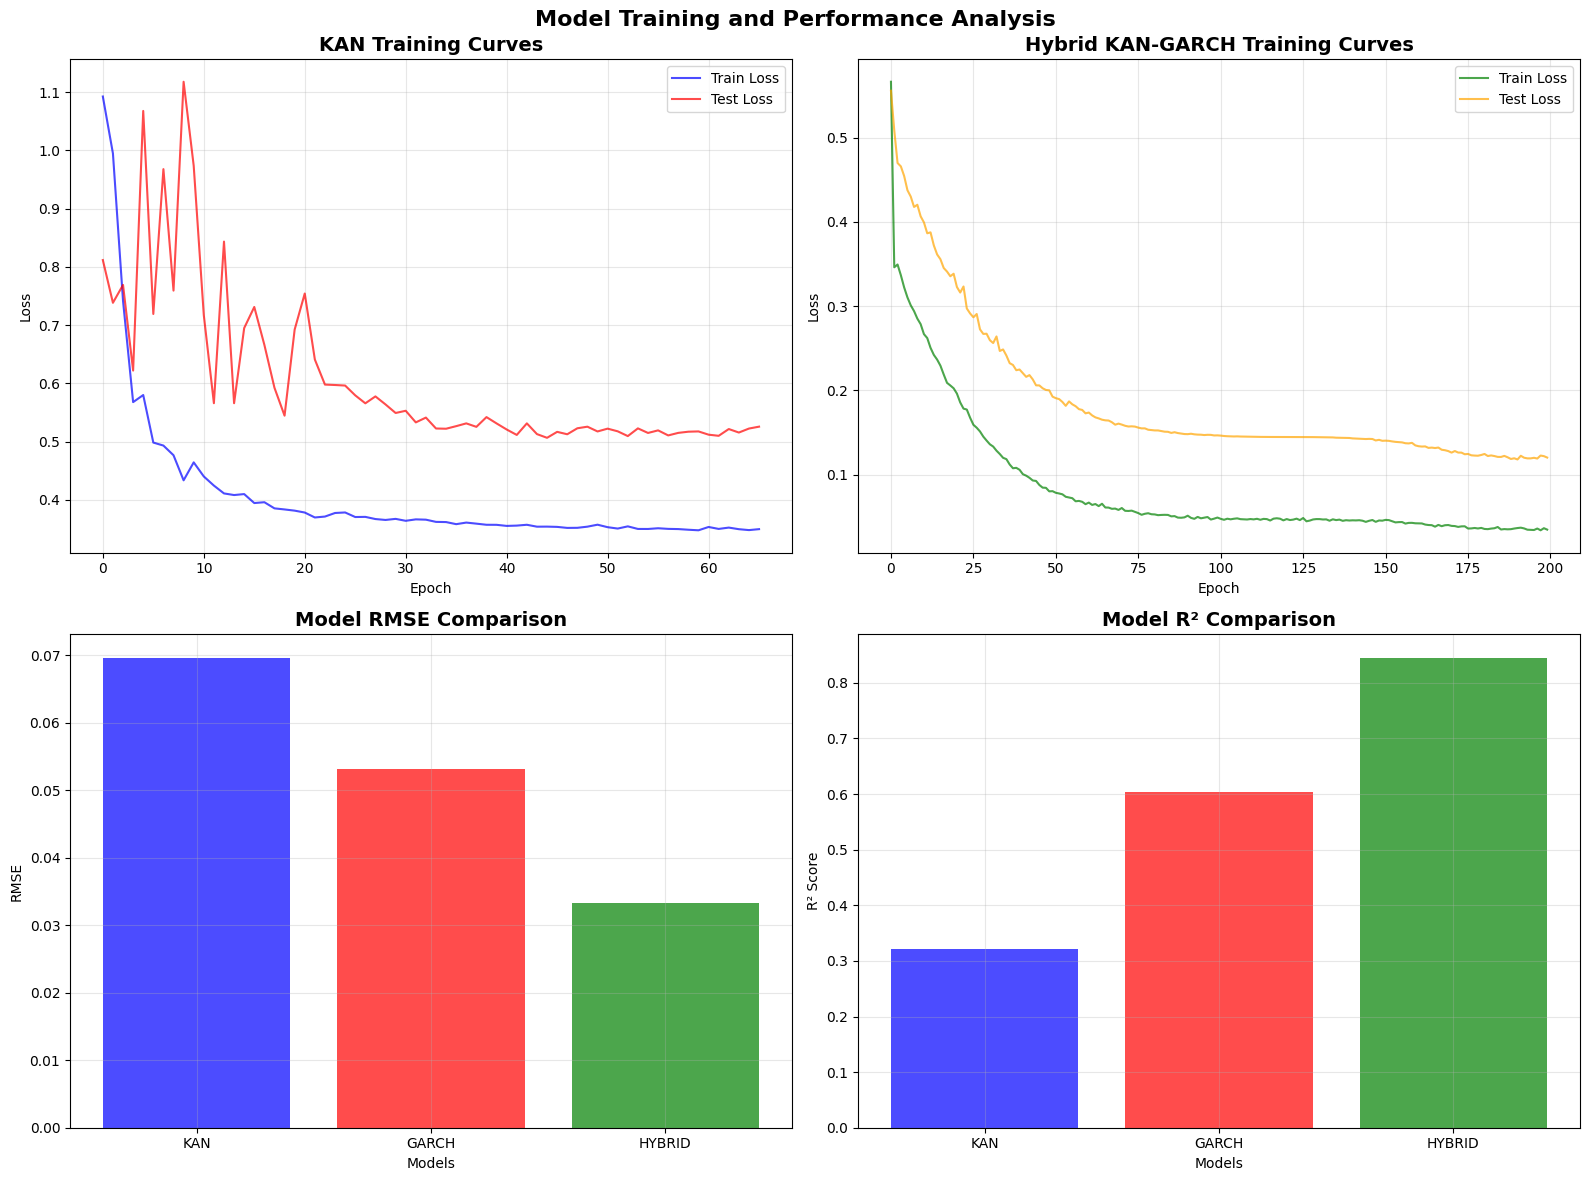

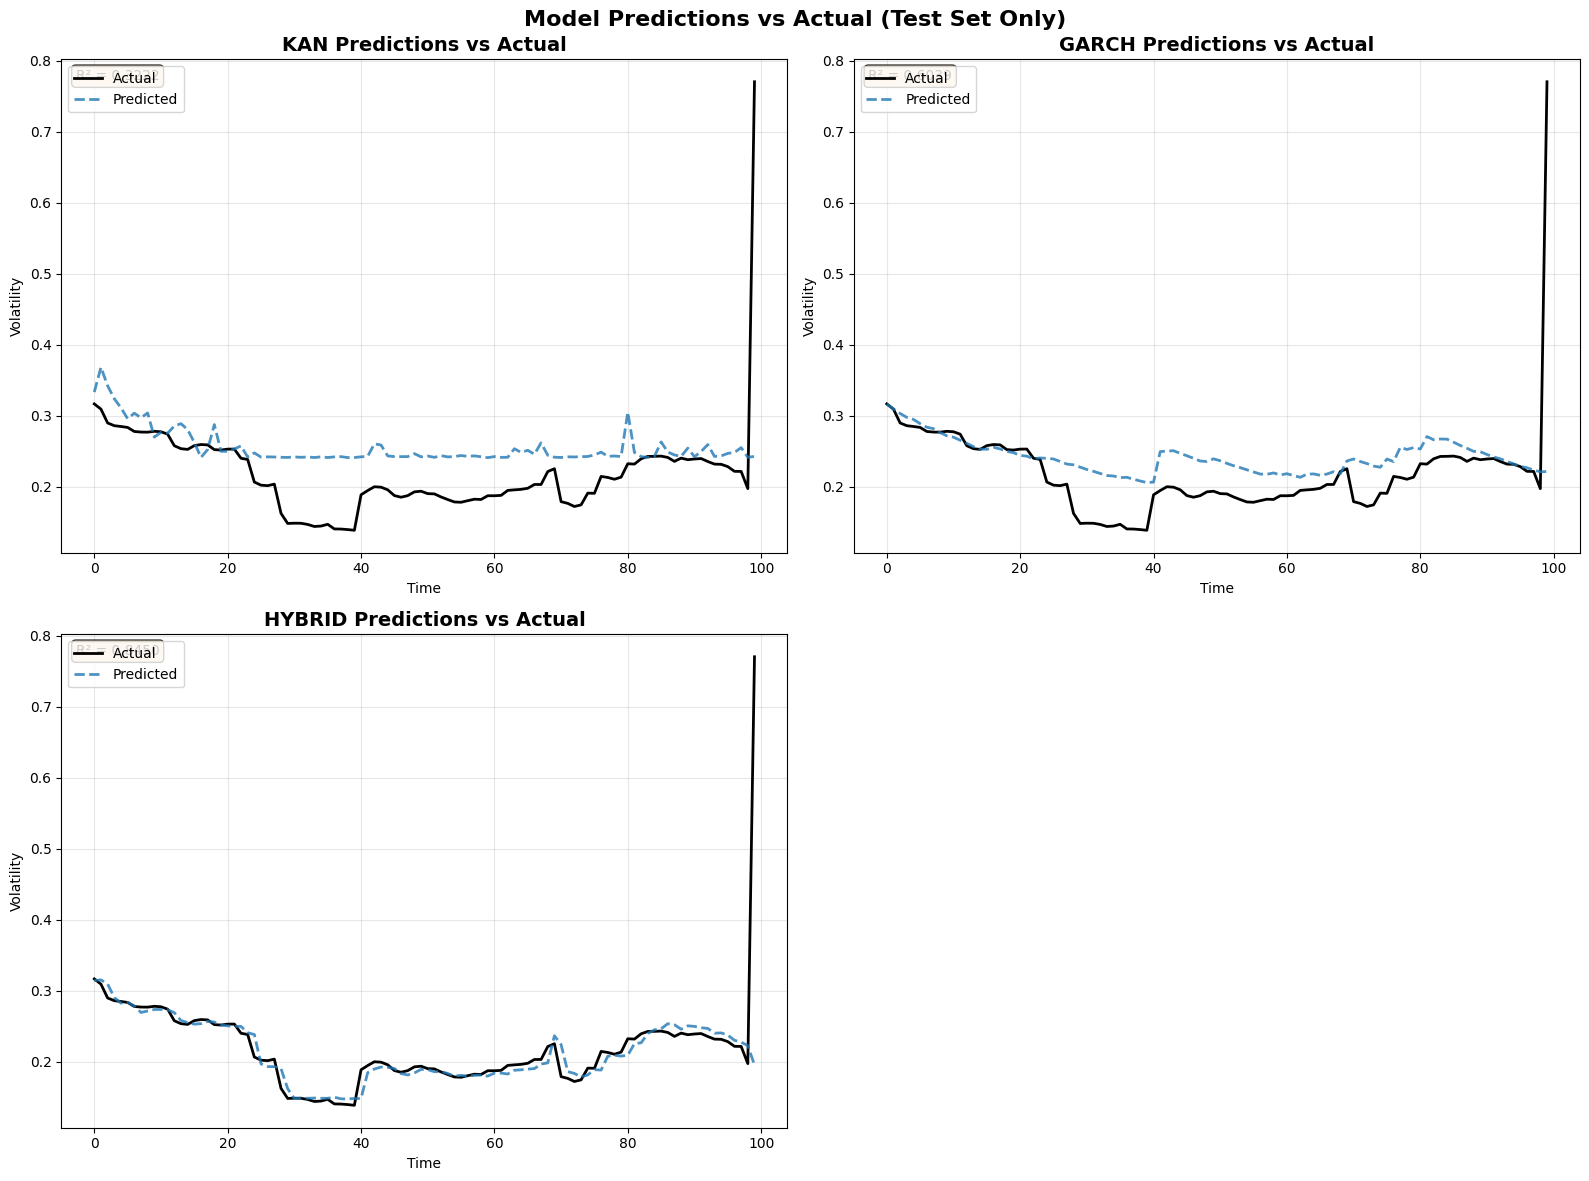

\n================================================================================
FULL TRAIN AND TEST DATA VISUALIZATION


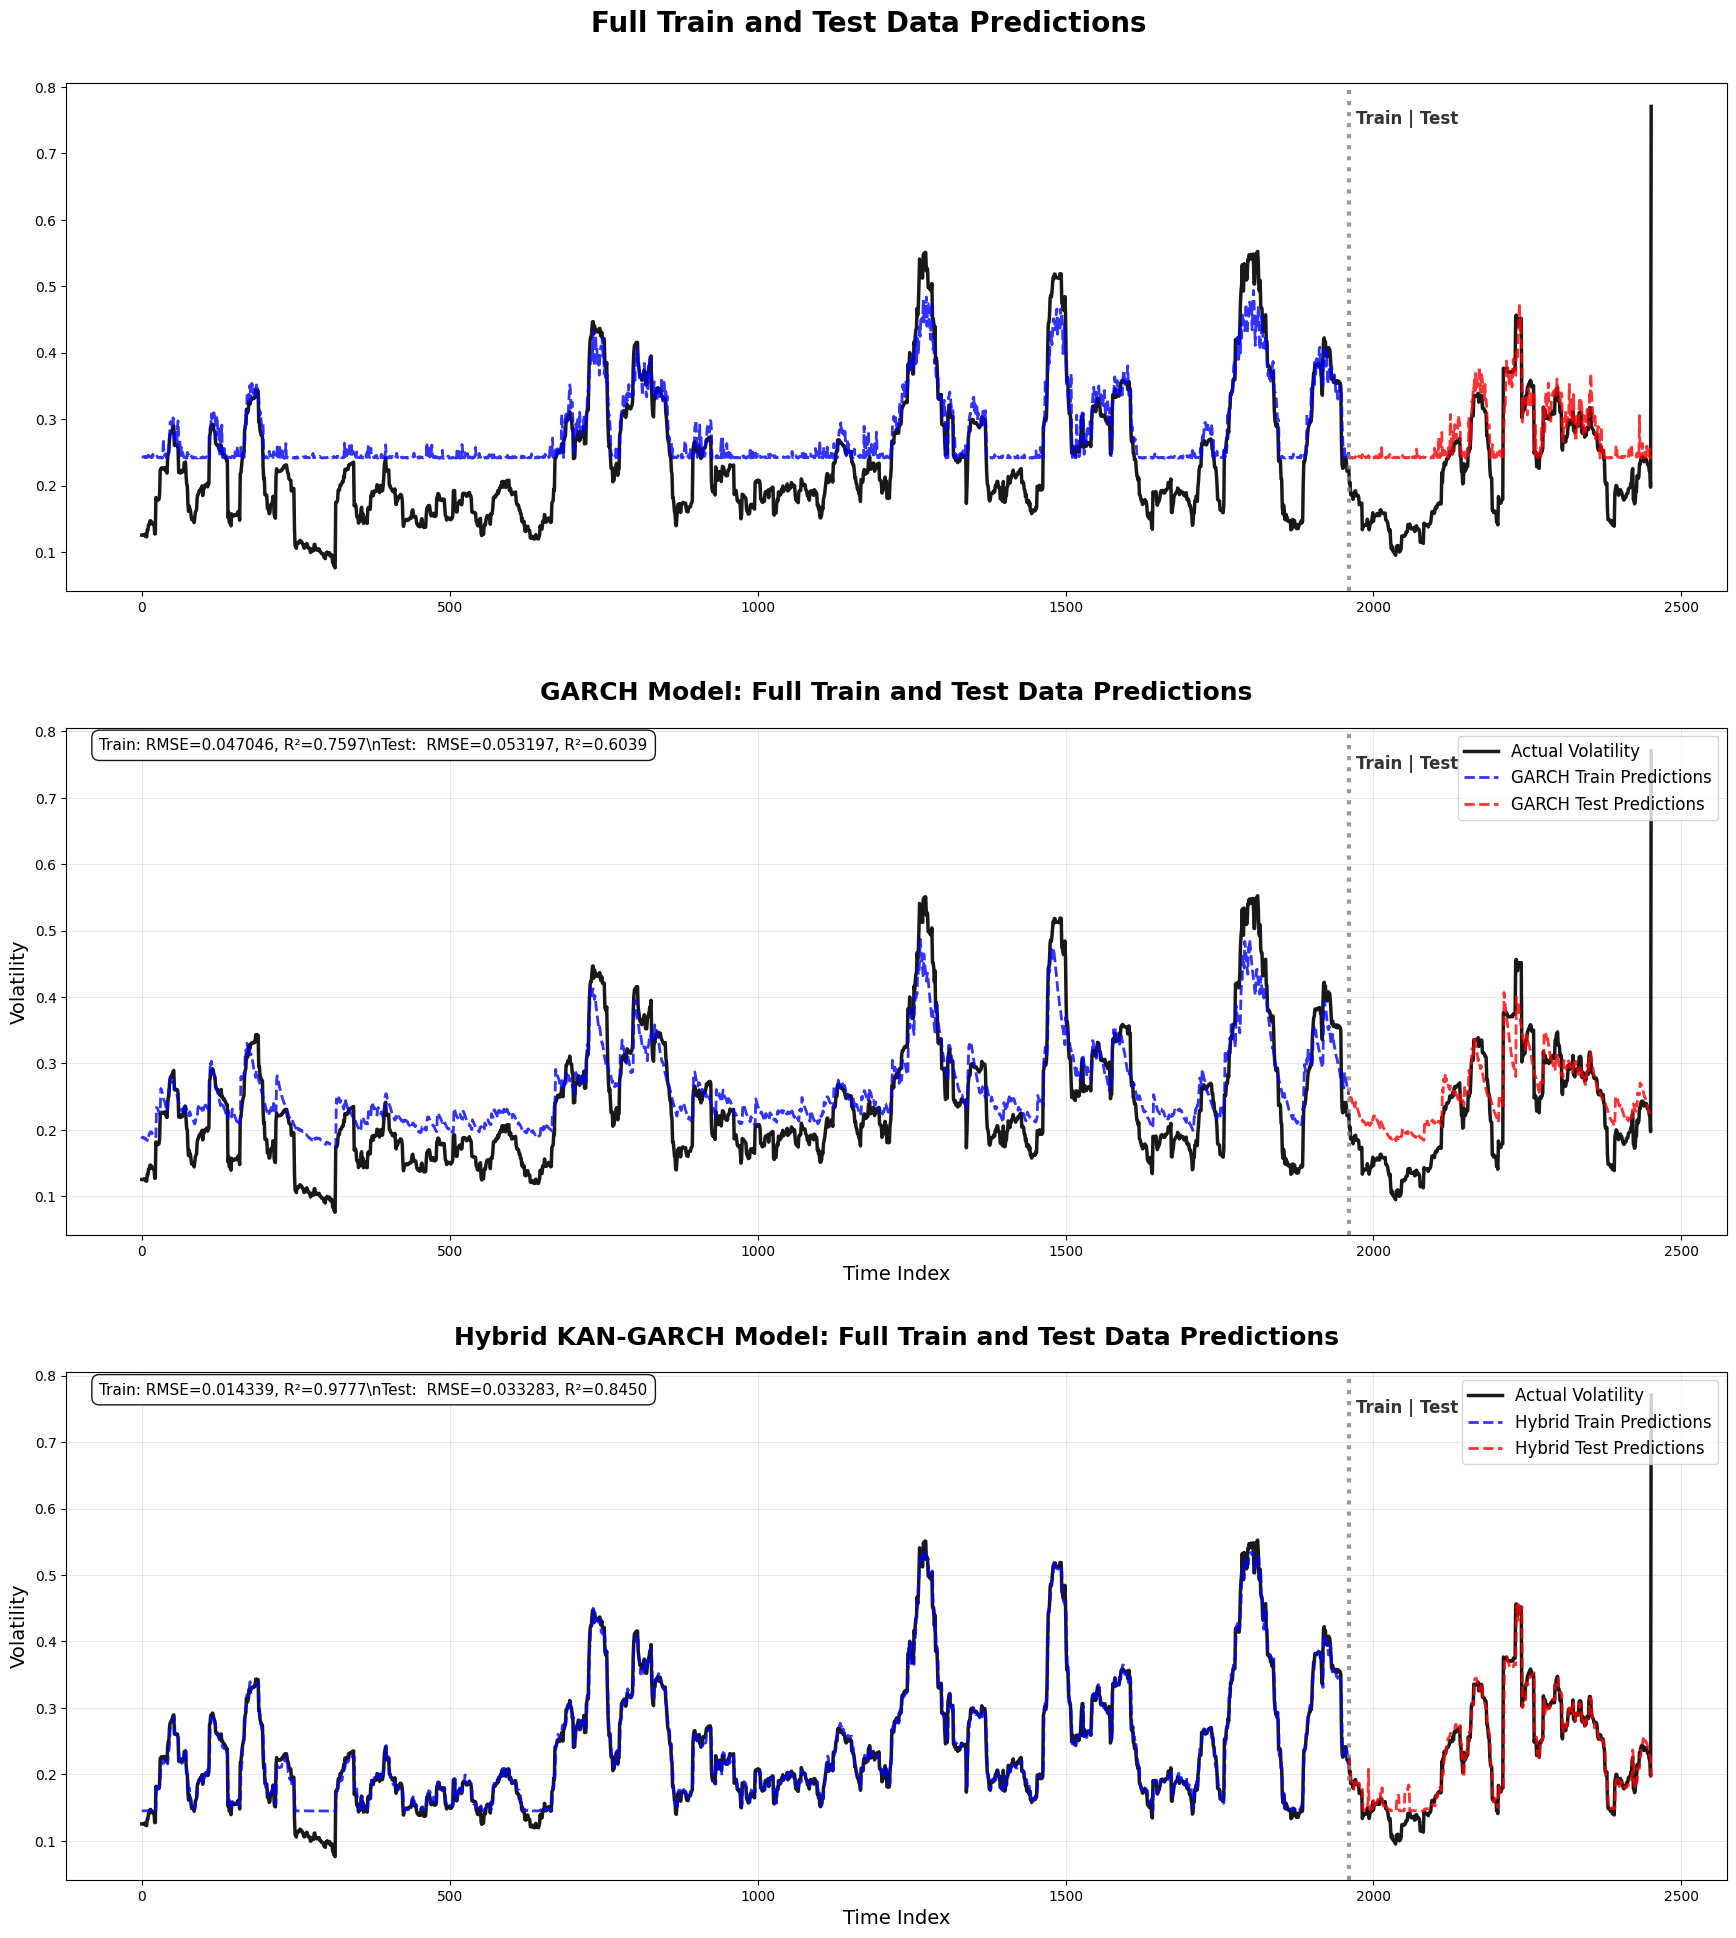

\n==========================================================================================
FULL DATASET PREDICTION SUMMARY
KAN Model Performance:
  Train - RMSE: 0.060197, R²: 0.6065
  Test  - RMSE: 0.069590, R²: 0.3222
  Generalization Gap (Test RMSE - Train RMSE): 0.009393

GARCH Model Performance:
  Train - RMSE: 0.047046, R²: 0.7597
  Test  - RMSE: 0.053197, R²: 0.6039
  Generalization Gap (Test RMSE - Train RMSE): 0.006151

HYBRID Model Performance:
  Train - RMSE: 0.014339, R²: 0.9777
  Test  - RMSE: 0.033283, R²: 0.8450
  Generalization Gap (Test RMSE - Train RMSE): 0.018944


SUMMARY FOR WINDOW 30
• Best overall model: HYBRID (lowest RMSE)
• Hybrid model outperforms both individual models

Using volatility windows: 40
Lookback period: 30
Creating volatility features...
Feature matrix shape: (2437, 17)
GARCH feature matrix shape: (2437, 3)
Target vector shape: (2437,)

TRAINING MODELS

1. Training KAN Model...
KAN Epoch 0: Train=1.078460, Test=0.768594
KAN Epoch 1: Train=1.003

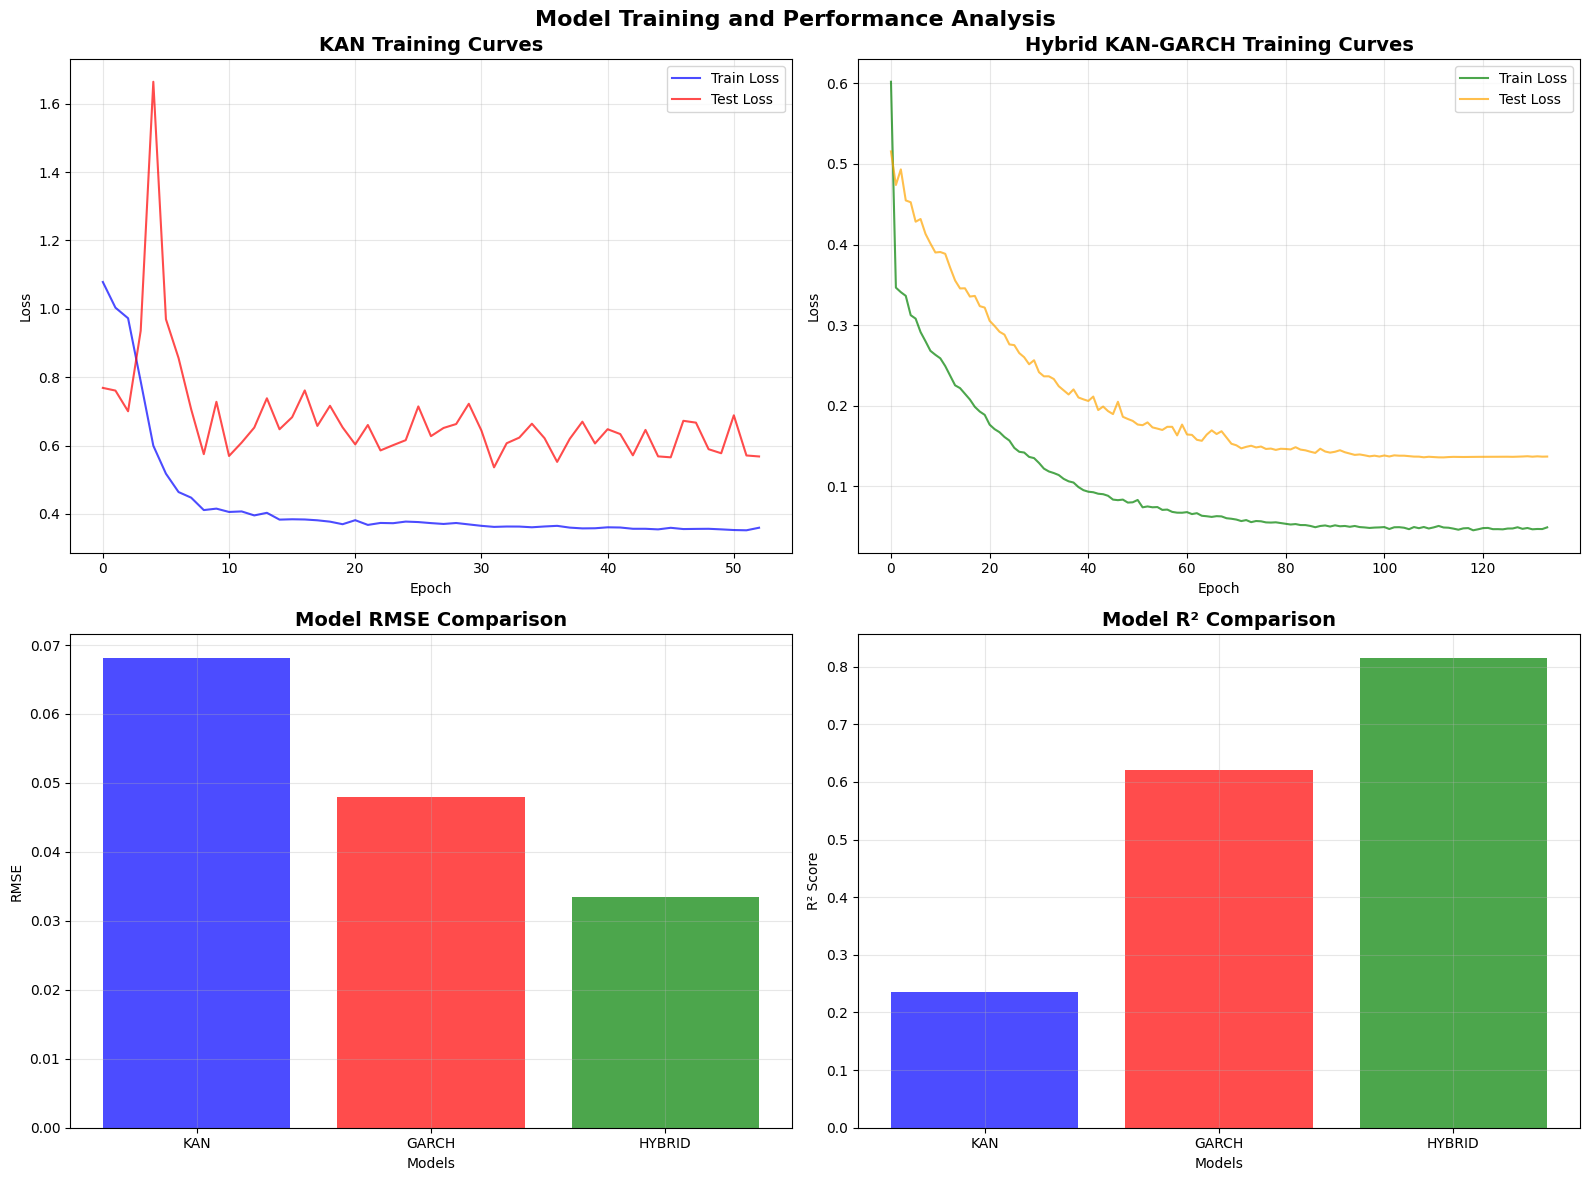

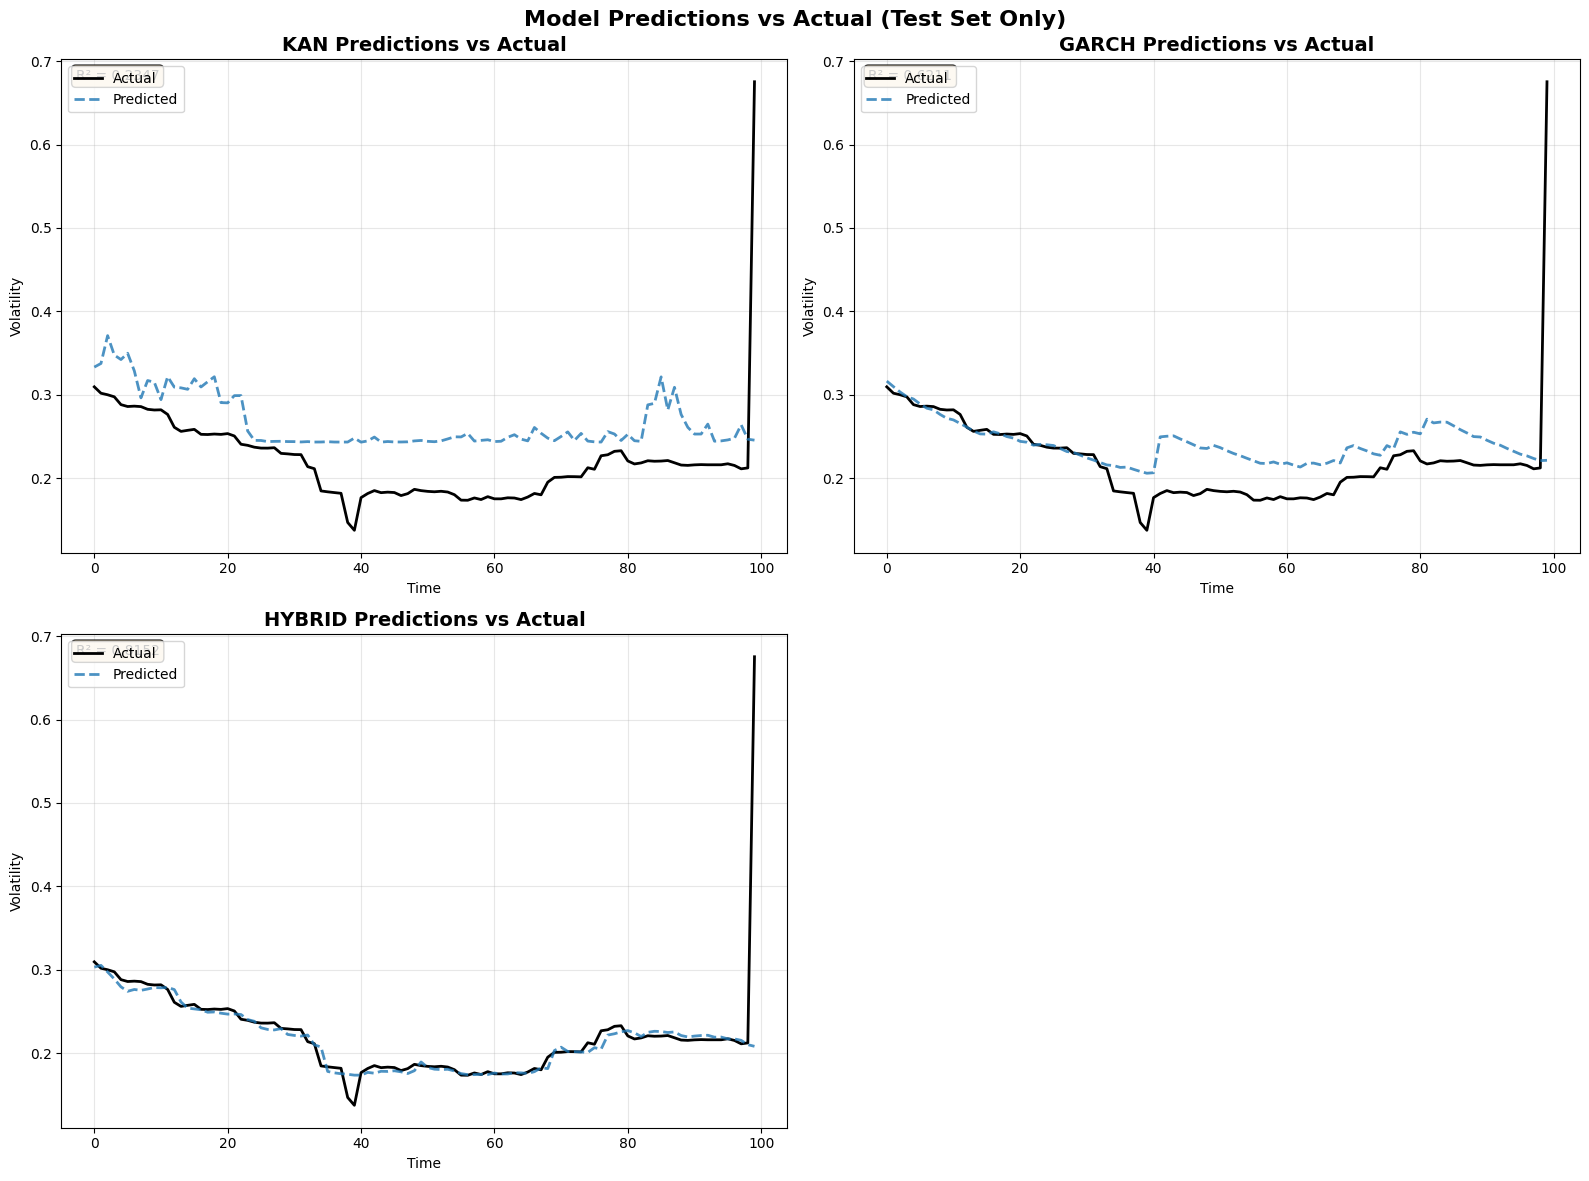

\n================================================================================
FULL TRAIN AND TEST DATA VISUALIZATION


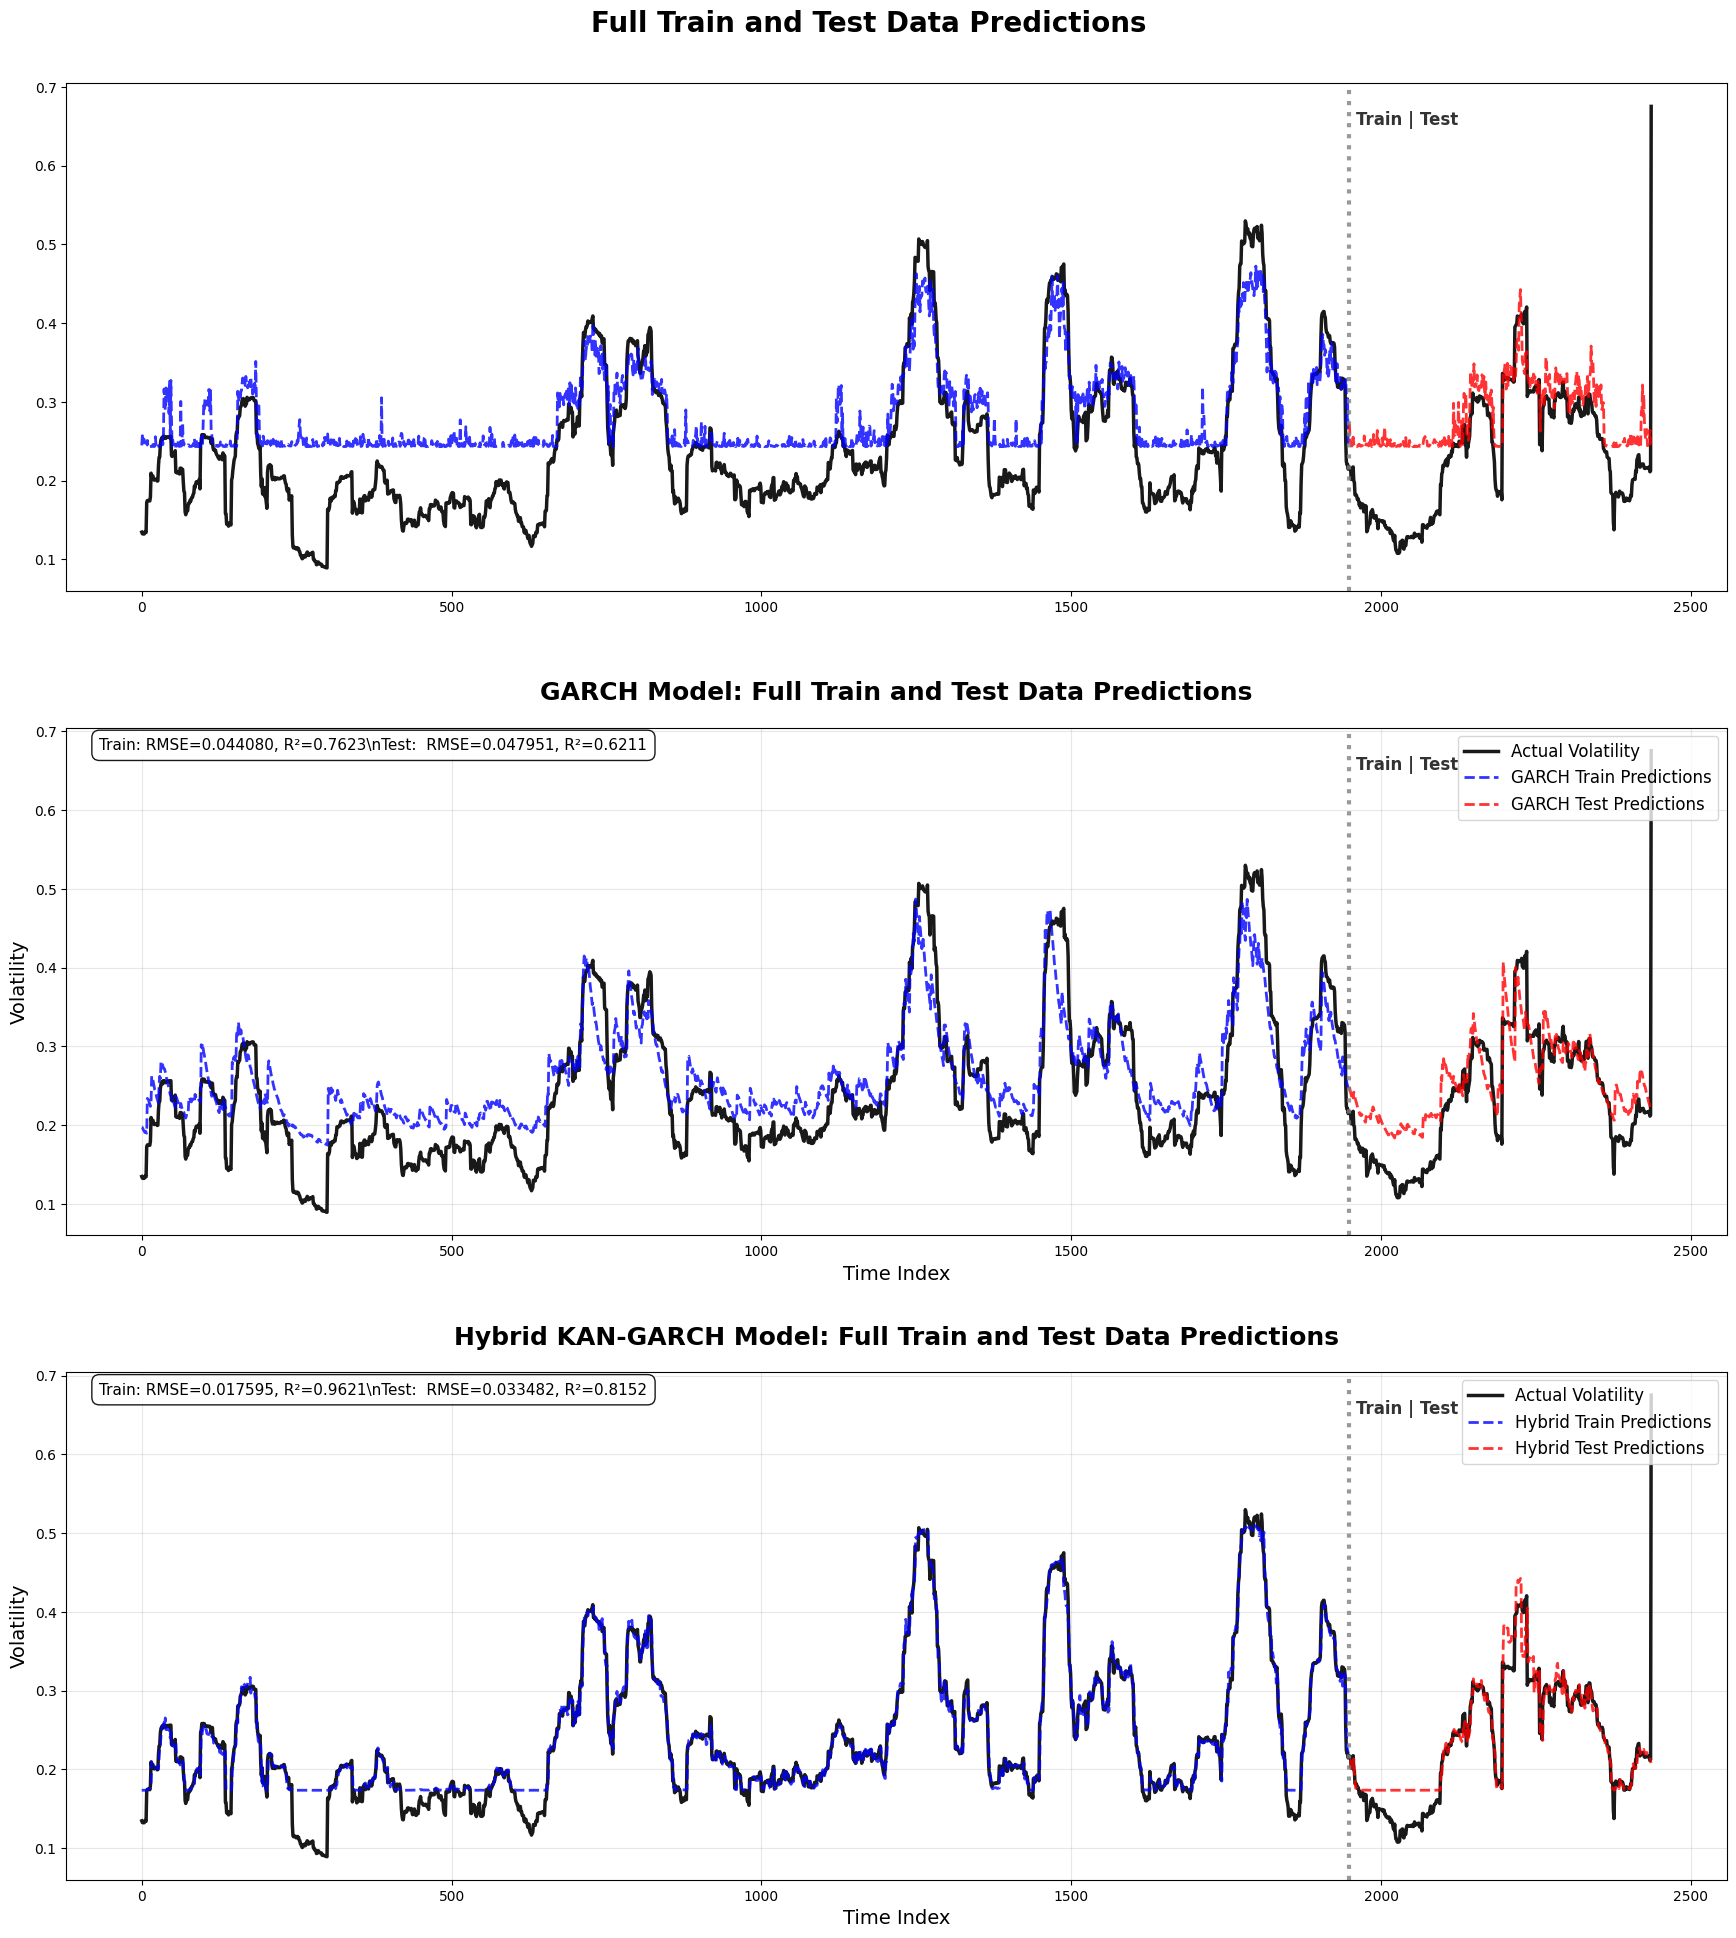

\n==========================================================================================
FULL DATASET PREDICTION SUMMARY
KAN Model Performance:
  Train - RMSE: 0.058716, R²: 0.5783
  Test  - RMSE: 0.068143, R²: 0.2347
  Generalization Gap (Test RMSE - Train RMSE): 0.009427

GARCH Model Performance:
  Train - RMSE: 0.044080, R²: 0.7623
  Test  - RMSE: 0.047951, R²: 0.6211
  Generalization Gap (Test RMSE - Train RMSE): 0.003872

HYBRID Model Performance:
  Train - RMSE: 0.017595, R²: 0.9621
  Test  - RMSE: 0.033482, R²: 0.8152
  Generalization Gap (Test RMSE - Train RMSE): 0.015887


SUMMARY FOR WINDOW 40
• Best overall model: HYBRID (lowest RMSE)
• Hybrid model outperforms both individual models

Using volatility windows: 50
Lookback period: 30
Creating volatility features...
Feature matrix shape: (2422, 17)
GARCH feature matrix shape: (2422, 3)
Target vector shape: (2422,)

TRAINING MODELS

1. Training KAN Model...
KAN Epoch 0: Train=1.092232, Test=0.775858
KAN Epoch 1: Train=0.992

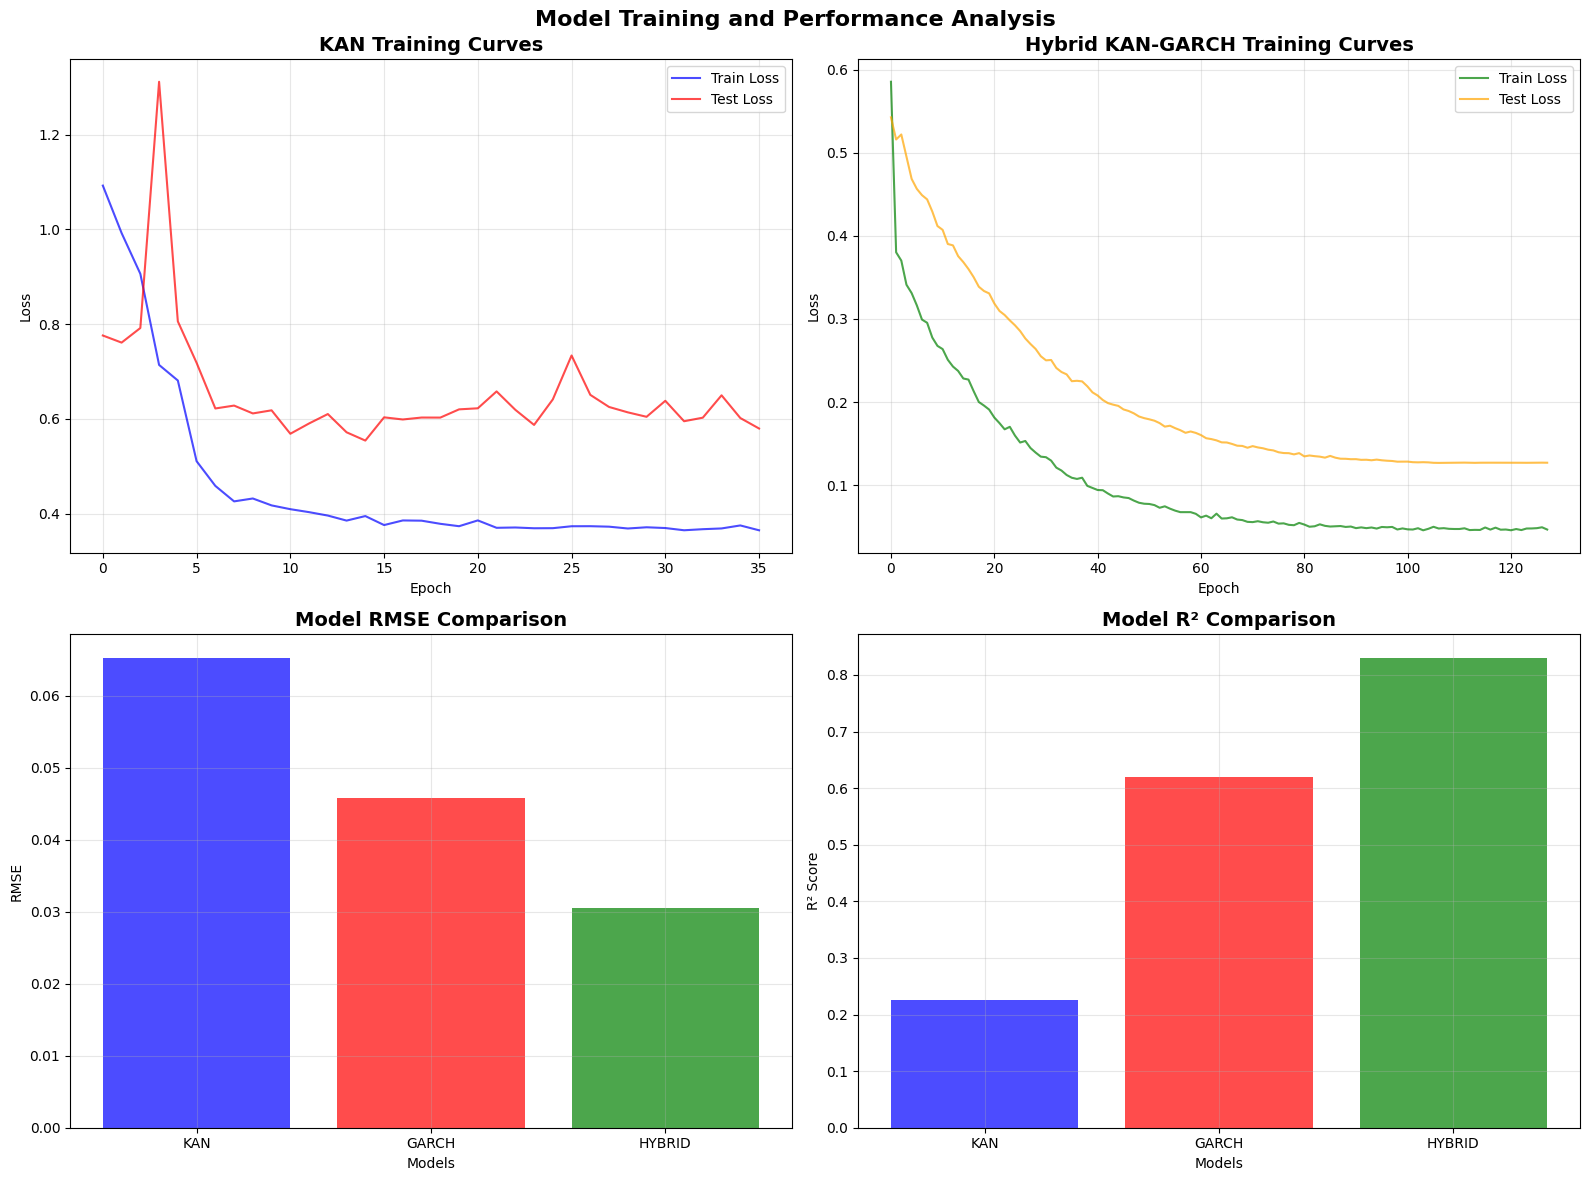

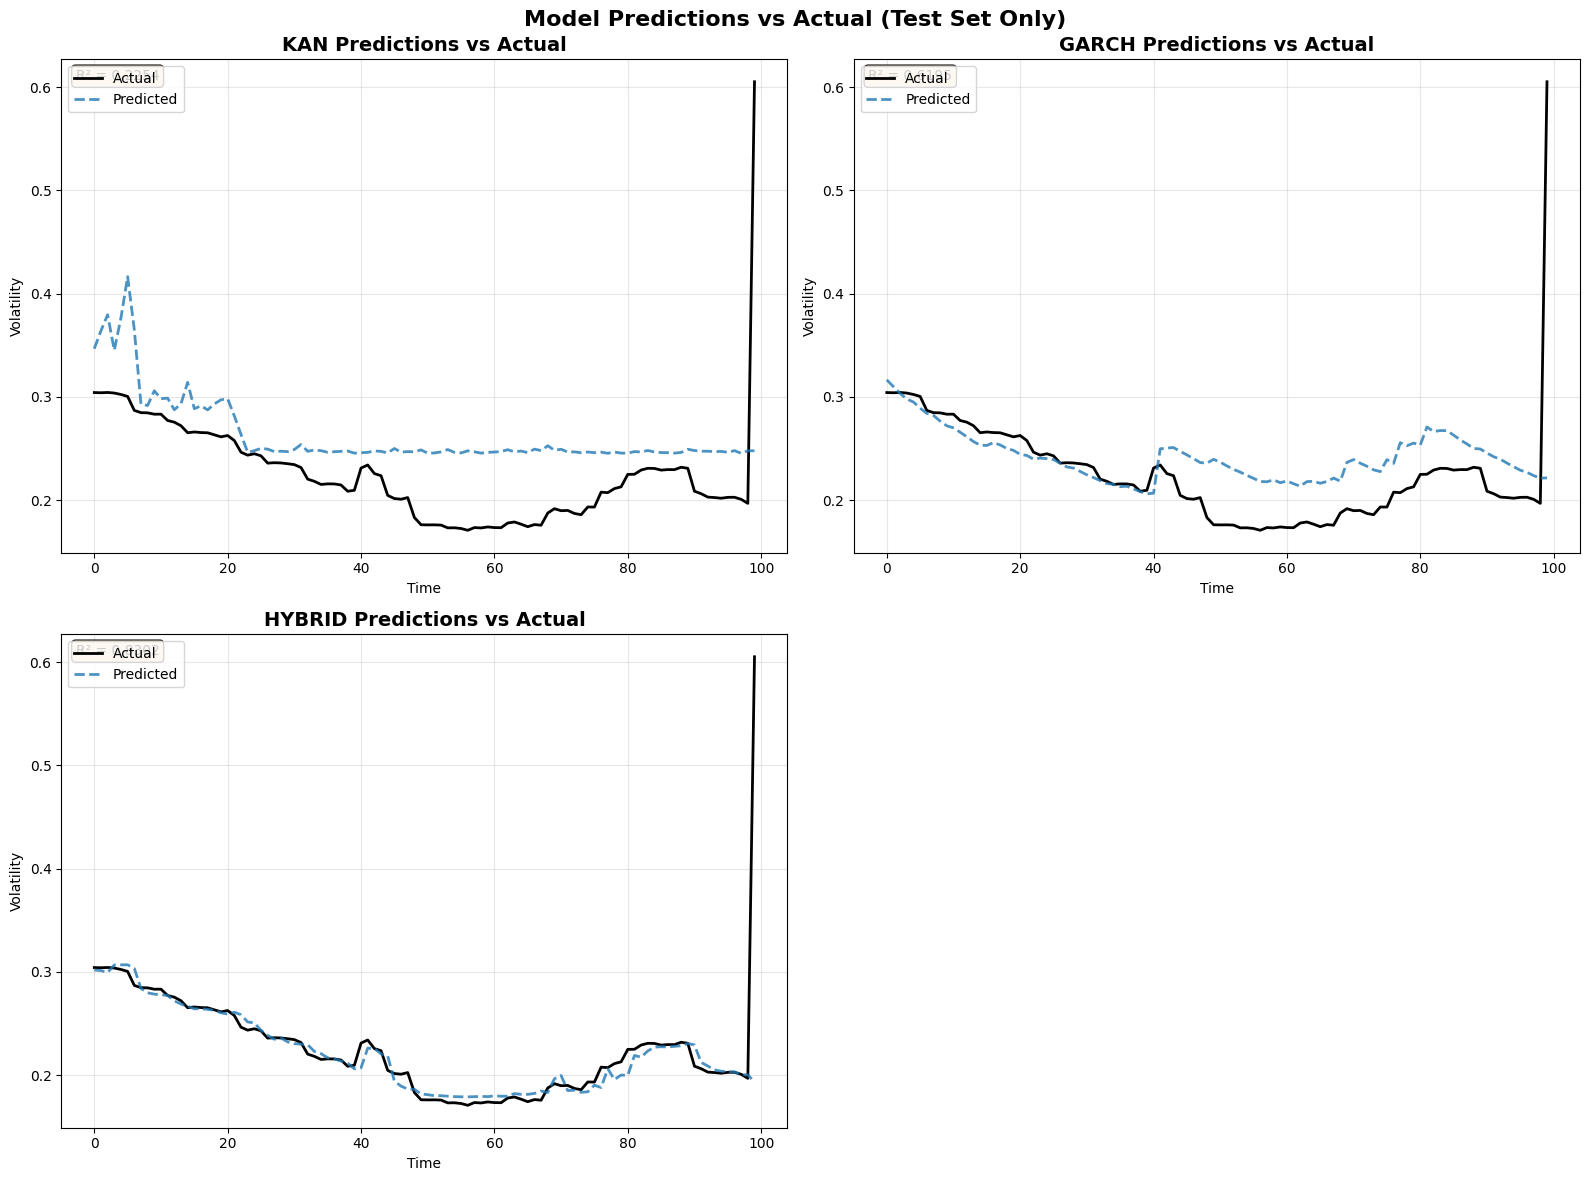

\n================================================================================
FULL TRAIN AND TEST DATA VISUALIZATION


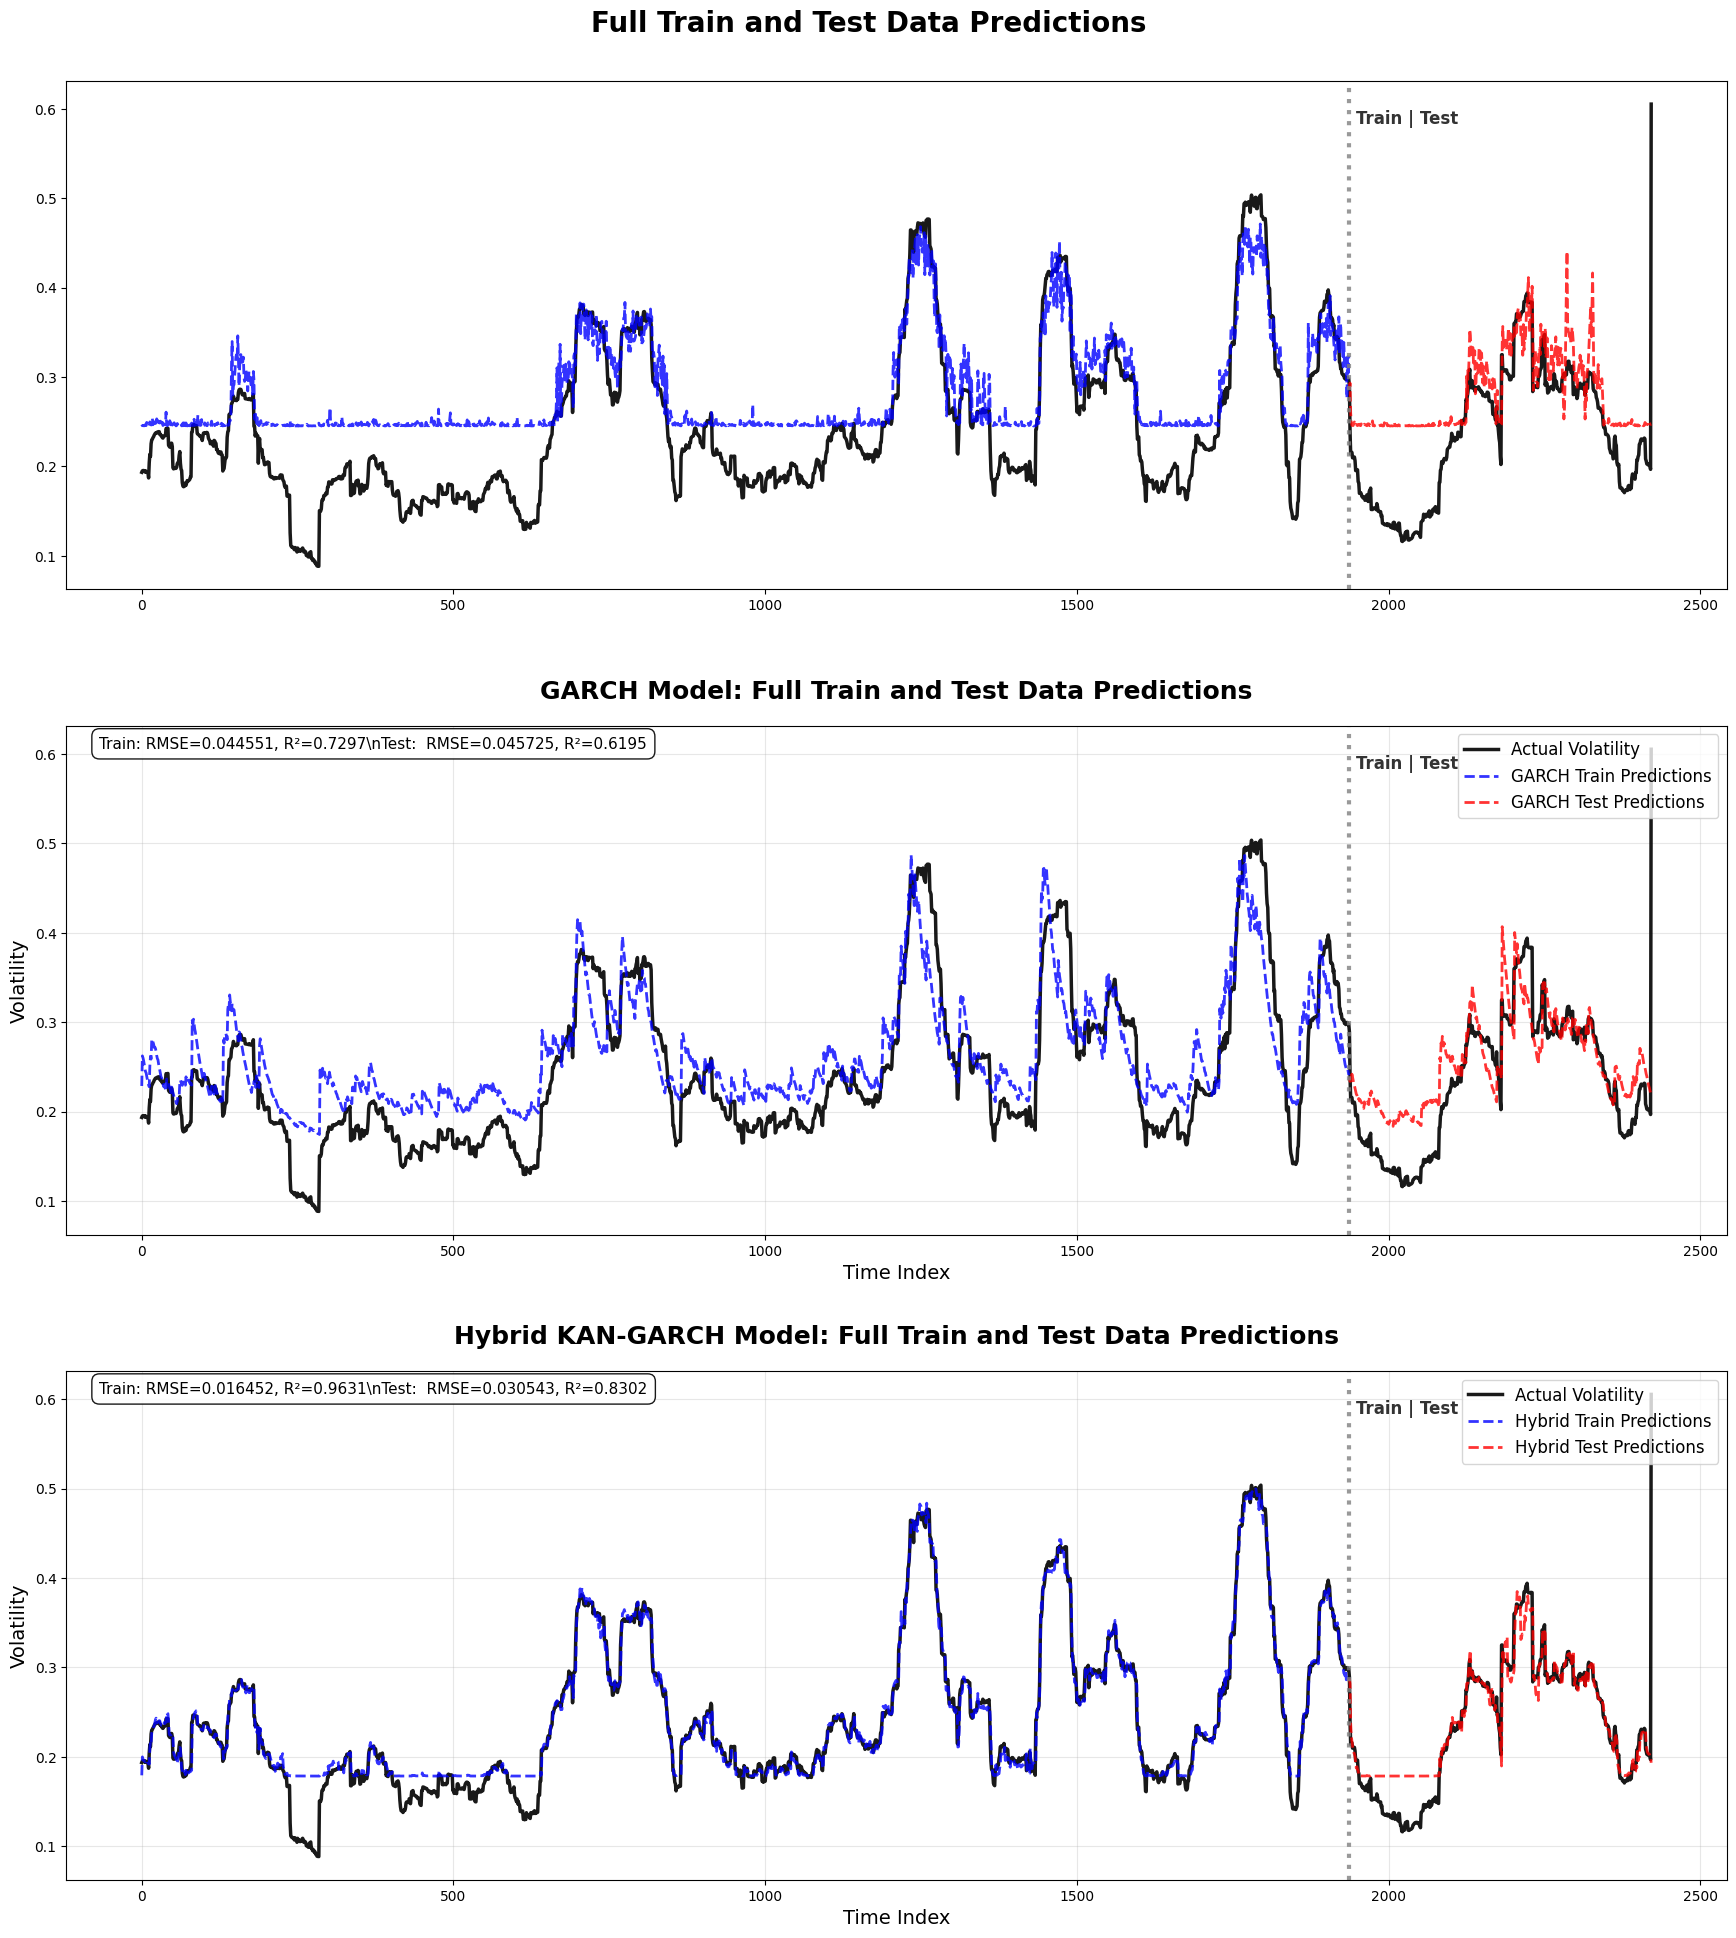

\n==========================================================================================
FULL DATASET PREDICTION SUMMARY
KAN Model Performance:
  Train - RMSE: 0.053893, R²: 0.6045
  Test  - RMSE: 0.065237, R²: 0.2254
  Generalization Gap (Test RMSE - Train RMSE): 0.011343

GARCH Model Performance:
  Train - RMSE: 0.044551, R²: 0.7297
  Test  - RMSE: 0.045725, R²: 0.6195
  Generalization Gap (Test RMSE - Train RMSE): 0.001174

HYBRID Model Performance:
  Train - RMSE: 0.016452, R²: 0.9631
  Test  - RMSE: 0.030543, R²: 0.8302
  Generalization Gap (Test RMSE - Train RMSE): 0.014091


SUMMARY FOR WINDOW 50
• Best overall model: HYBRID (lowest RMSE)
• Hybrid model outperforms both individual models

Using volatility windows: 60
Lookback period: 30
Creating volatility features...
Feature matrix shape: (2407, 17)
GARCH feature matrix shape: (2407, 3)
Target vector shape: (2407,)

TRAINING MODELS

1. Training KAN Model...
KAN Epoch 0: Train=1.060918, Test=0.837661
KAN Epoch 1: Train=1.018

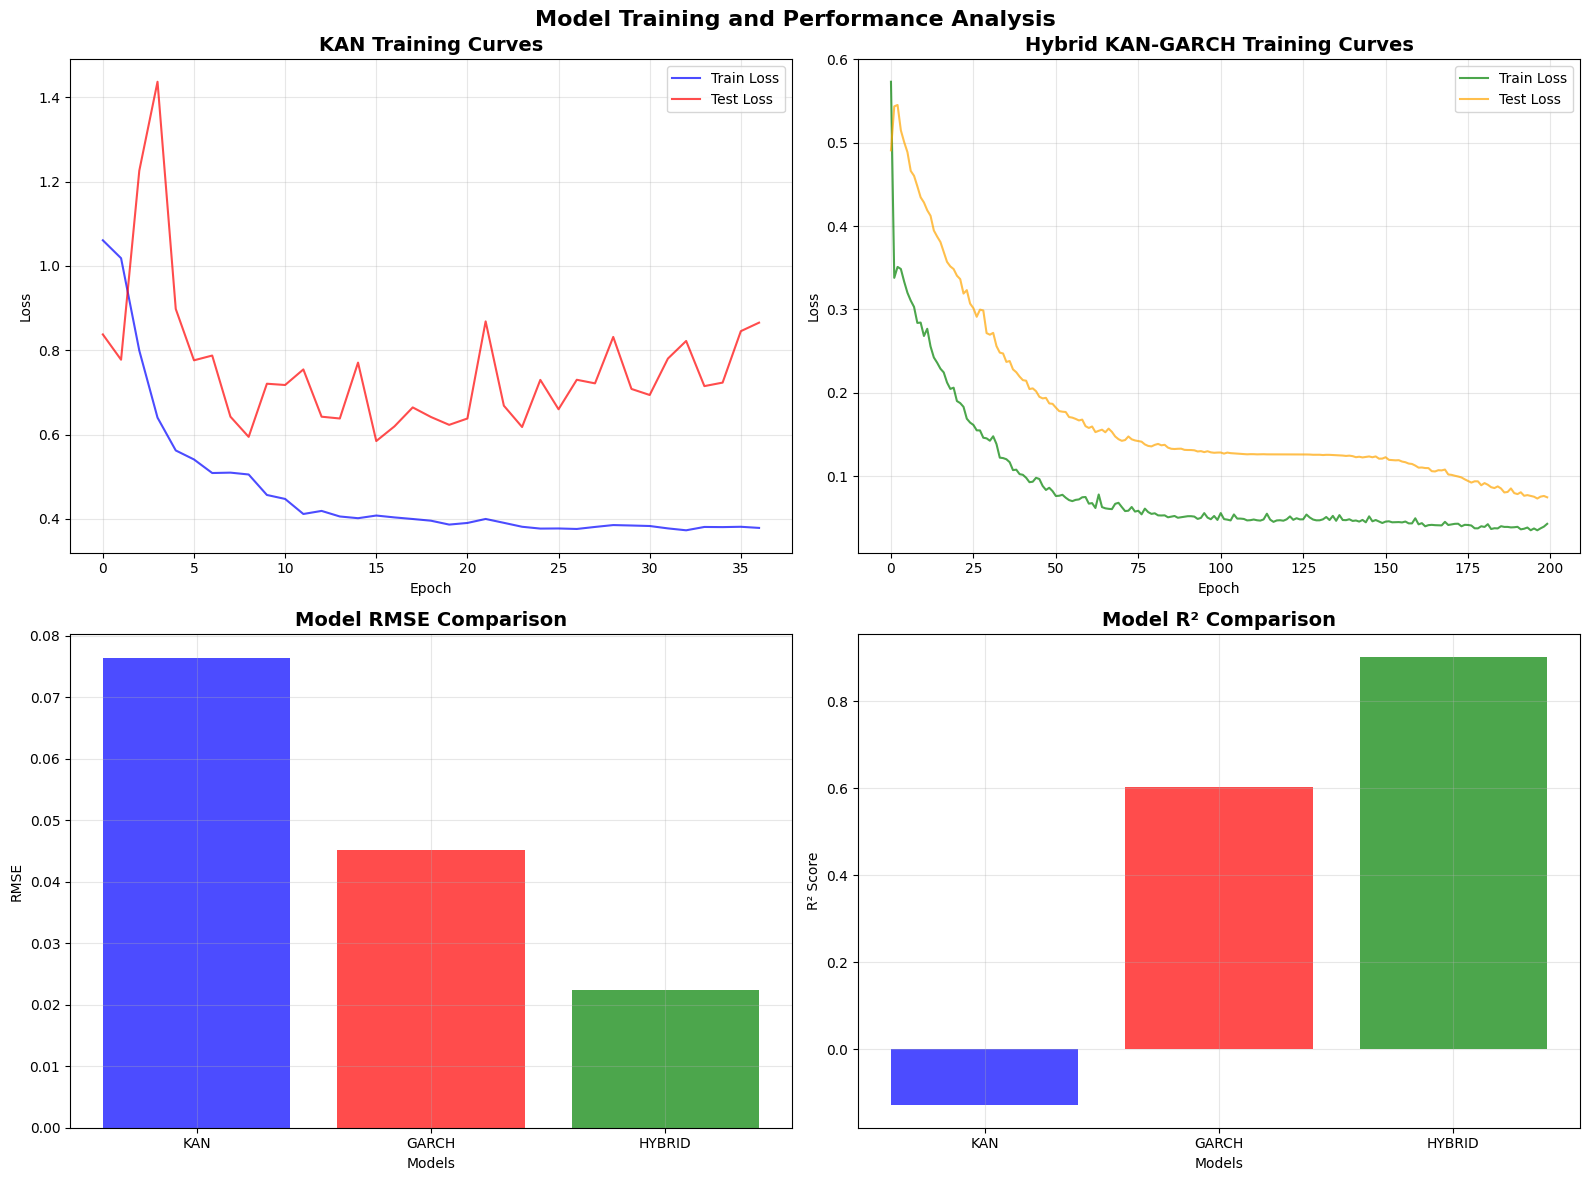

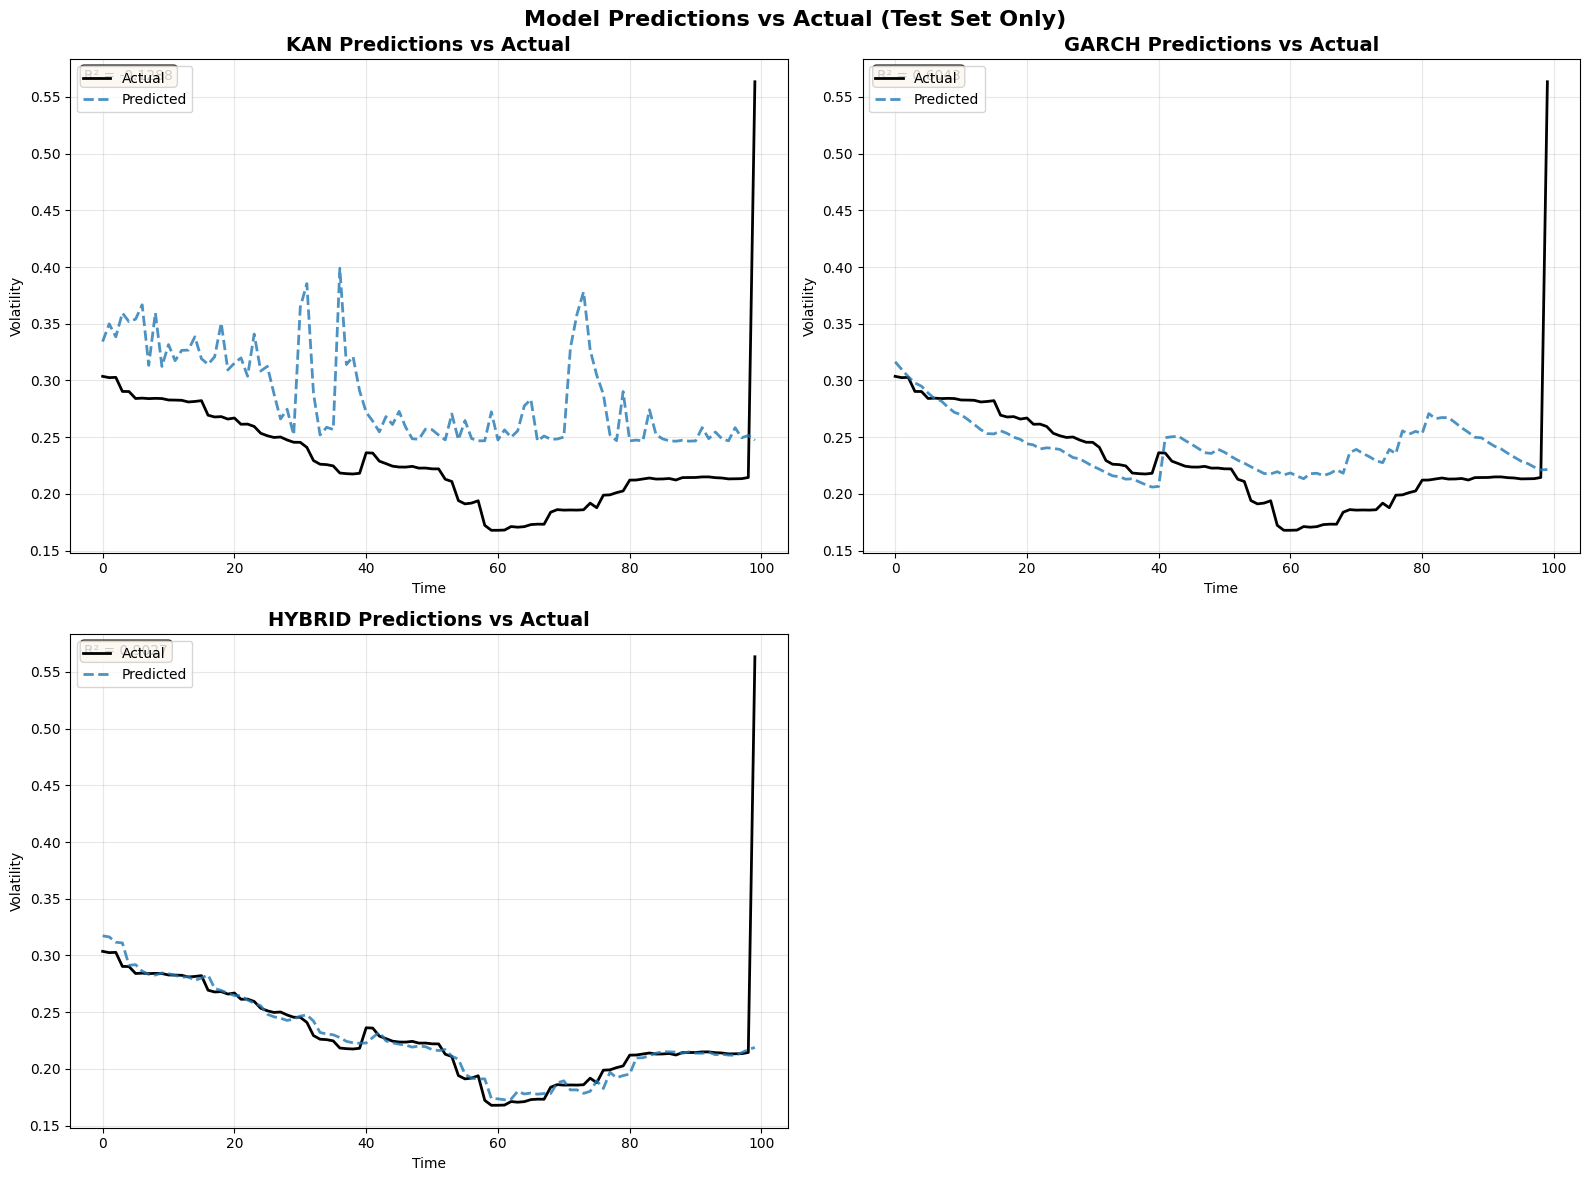

\n================================================================================
FULL TRAIN AND TEST DATA VISUALIZATION


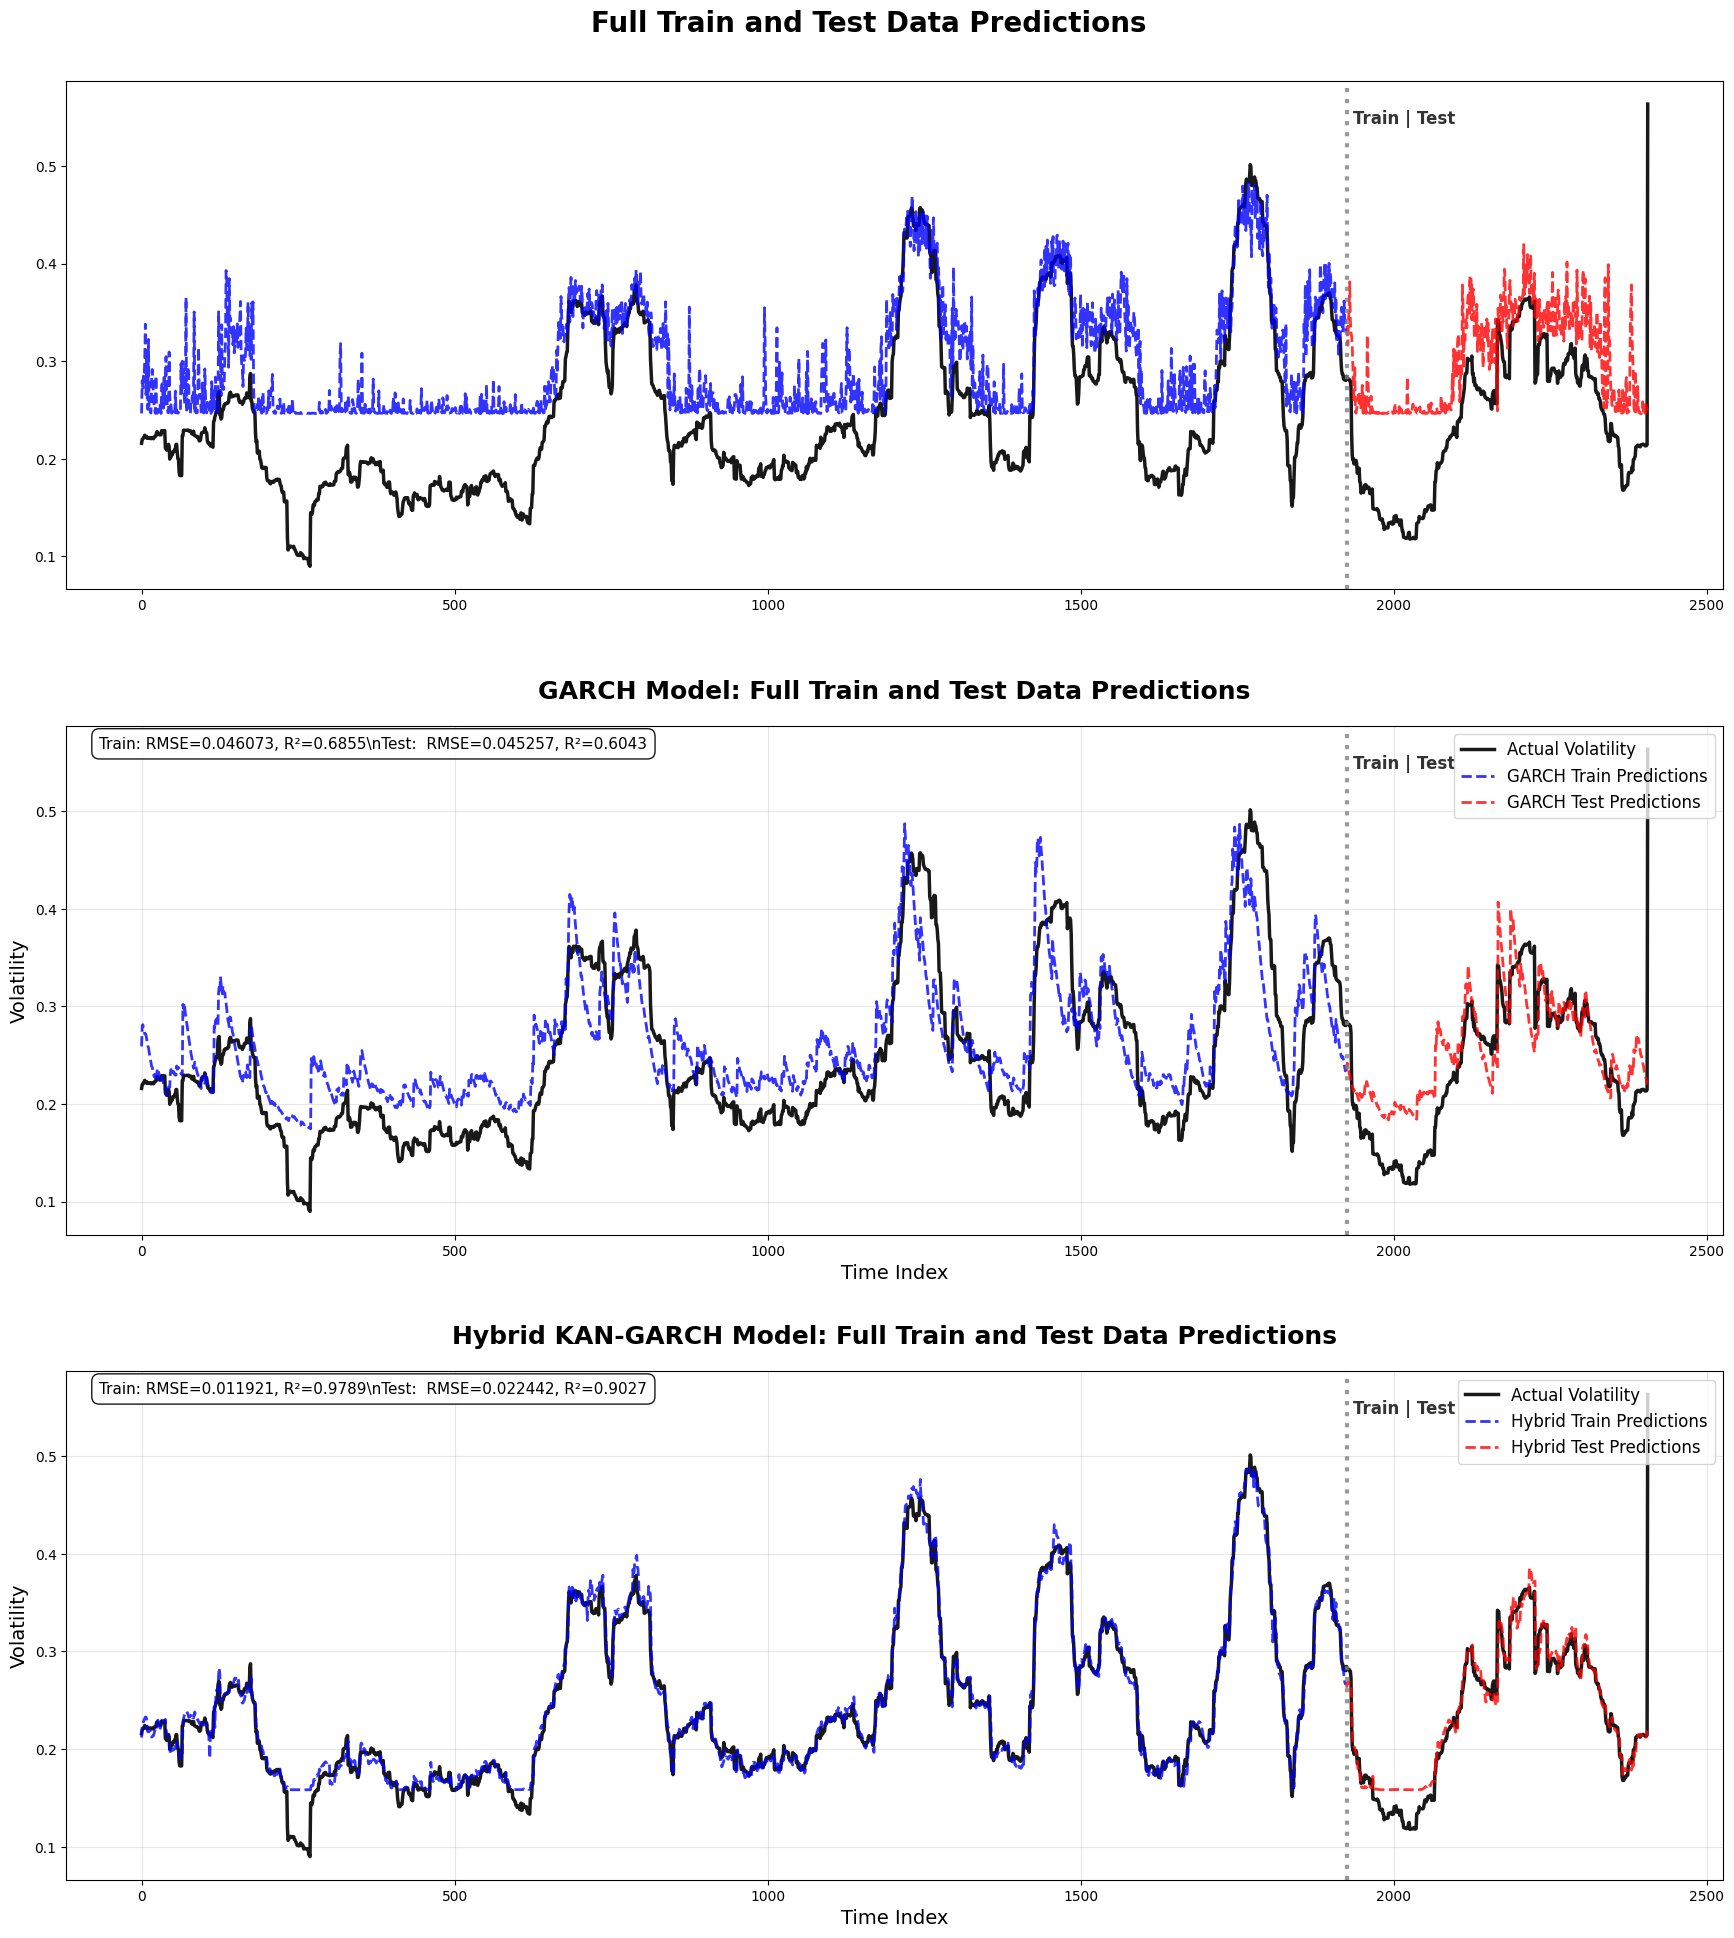

\n==========================================================================================
FULL DATASET PREDICTION SUMMARY
KAN Model Performance:
  Train - RMSE: 0.061022, R²: 0.4484
  Test  - RMSE: 0.076440, R²: -0.1288
  Generalization Gap (Test RMSE - Train RMSE): 0.015418

GARCH Model Performance:
  Train - RMSE: 0.046073, R²: 0.6855
  Test  - RMSE: 0.045257, R²: 0.6043
  Generalization Gap (Test RMSE - Train RMSE): -0.000816

HYBRID Model Performance:
  Train - RMSE: 0.011921, R²: 0.9789
  Test  - RMSE: 0.022442, R²: 0.9027
  Generalization Gap (Test RMSE - Train RMSE): 0.010521


SUMMARY FOR WINDOW 60
• Best overall model: HYBRID (lowest RMSE)
• Hybrid model outperforms both individual models

COMPARISON ACROSS ALL WINDOWS
Window 30: Best = HYBRID (RMSE: 0.033283, R²: 0.8450)
Window 40: Best = HYBRID (RMSE: 0.033482, R²: 0.8152)
Window 50: Best = HYBRID (RMSE: 0.030543, R²: 0.8302)
Window 60: Best = HYBRID (RMSE: 0.022442, R²: 0.9027)


In [ ]:
if __name__ == "__main__":
    all_results = main()